In [1]:
import os
os.listdir('SMF_screenshots_enriched/screenshots')

['screenshots0000_278256147',
 'screenshots0000_-768362949',
 'screenshots0000_1001230178',
 'screenshots0000_-614790945',
 'screenshots0000_-313913851',
 'screenshots0000_-1908324312',
 'screenshots0000_1884302156',
 'screenshots0000_1632951771',
 'screenshots0000_1596194321',
 'screenshots0000_960084647',
 'screenshots0000_-1018583566',
 'screenshots0000_597332220',
 'screenshots0000_-173303524',
 'screenshots0000_359803652',
 'screenshots0000_-2051541877',
 'screenshots0000_-144949485',
 'screenshots0000_1144804095',
 'screenshots0000_-930571042',
 'screenshots0000_1102749281',
 'screenshots0000_-1400619731',
 'screenshots0000_2071151445',
 'screenshots0000_1799592399',
 'screenshots0000_324086719',
 'screenshots0000_-697367471',
 'screenshots0000_-1458162892',
 'screenshots0000_-1586032352',
 'screenshots0000_-966620744',
 'screenshots0000_-1999949309',
 'screenshots0000_513248992']

In [4]:
os.getcwd()

'/BystrovA'

In [2]:
import os
import re

import torch
import numpy as np
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import datasets
from torchvision import transforms
from torch import nn
from torch.nn import functional as F
import random
import torchvision.utils as vutils
import argparse
import math
import cv2
from matplotlib import pyplot as plt

from torchsummary import summary

from abc import abstractmethod

# Root directory for dataset
# dataroot = "fish_screenshots_test/"
dataroot = 'SMF_screenshots_enriched/screenshots'

# Number of workers for dataloader
num_workers = 4

# Batch size during training
batch_size = 256

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

embedding_image_size = 4

# Number of channels in the training images. For color images this is 3
in_channels = 2

# Size of z latent vector
nz = 100

# Number of training epochs
num_epochs = 50 # Original is 5 on a dataset of 1 million

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 3

num_training_updates = 15000

num_hiddens = 64

embedding_dim = 64
num_embeddings = 64

commitment_cost = 0.25
vq_coef = 0

decay = 0.99

learning_rate = 1e-3

num_channels = 1


entropy_weight = 1
kld_weight = 0.00025

aperture_size = 5

In [3]:
# Set random seed for reproducibility
seed = 1141
# seed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", seed)
random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda:8" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

Random Seed:  1141


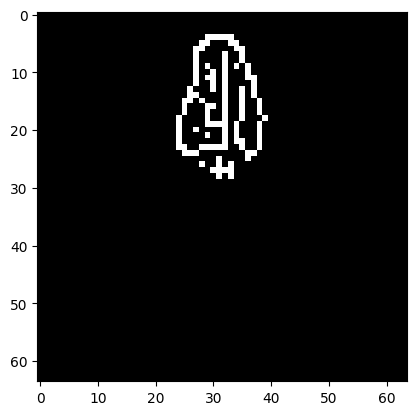

In [6]:
zero_screenshot_path = 'Sadistic_Music_Factory_screenshots/Sadistic_Music_Factory/Zero_screenshot.png'
zero_screenshot = cv2.imread(zero_screenshot_path, 0)
zero_screenshot = fullscreen_transform(zero_screenshot, dim=[image_size,image_size], aperture_size=aperture_size)
zero_screenshot_tensor = torch.Tensor(zero_screenshot).to(device).detach()
plt.imshow(zero_screenshot, cmap='gray')

In [7]:
fpath = r'SMF_screenshots_enriched/screenshots_add/screenshots0000_359803652/12.txt'

def extract_metadata(fpath):
    
    with open(fpath, 'r') as file:
        info = file.read().rstrip()
        
#     info = re.findall(r'/\d.+',fpath)[0][1:-len('.png')]
    info_splited = info.split('_')
    
    timestep = int(info_splited[0])
    reward = int(info_splited[1])
    player_x = int(info_splited[2])
    player_y = int(info_splited[3])
    
#     if timestep % 6 == 1:
#         step1_path = re.sub(info, '_'.join(info_splited), string)
    
    movements = info_splited[4].split(';')[:-1]
    
    walk_distance = jump_height = jump_true = 0
    
    for i in range(len(movements)):
        
        movement_list = [int(x) for x in list(movements[i])]
        
        if movement_list[0] == 1:
            walk_distance -= 1
            
        if movement_list[1] == 1:
            walk_distance += 1
        
        if movement_list[2] == 1:
            jump_true = 1
        
        # Если jumpt_true == 0, то не делаем ничего
        if (movement_list[3] == 0) and (jump_true == 1):
            jump_height += 1
        elif (movement_list[3] == 1) and (jump_true == 1):
            jump_height += 1
            jump_true = 0
        
    return timestep, reward, player_x, player_y, walk_distance, jump_height

extract_metadata(fpath)

(18, 0, 72, 510, 0, 5)

In [13]:
def take_screen_part(img, player_x, player_y, width, height, pad):
    img = np.pad(img,pad)
    return img[pad+player_y-height:pad+player_y+height,pad+player_x-width:pad+player_x+width]

In [14]:
def fullscreen_transform(img, dim=[image_size,image_size], pad = 32, zero_screenshot=None,aperture_size=aperture_size):
    img = img[pad:-pad, pad:-pad]
    img = cv2.resize(img, dim)
    img = cv2.Canny(img,150,250, apertureSize=aperture_size)
    if zero_screenshot is not None:
            img = (img != zero_screenshot) * img
    return img

def partscreen_transform(img, dim=[image_size,image_size], zero_screenshot=None, aperture_size=aperture_size):
    img = cv2.resize(img, dim)
    img = cv2.Canny(img,150,250, apertureSize=aperture_size)
    if zero_screenshot is not None:
            img = (img != zero_screenshot) * img
    return img

def transform_img(img, dim=[image_size,image_size], part_size=None, player_x=None, player_y=None, zero_screenshot=None, aperture_size=aperture_size):
    
#     img = cv2.imread(image_path, 0)
    if part_size==None:
        img = fullscreen_transform(img, dim, zero_screenshot=zero_screenshot, aperture_size=aperture_size)
    else:
        img = take_screen_part(img, player_x, player_y, part_size, part_size, part_size)
        img = partscreen_transform(img, dim, zero_screenshot=zero_screenshot, aperture_size=aperture_size)
    return img

class EdgesDataset(datasets.ImageFolder):
    def __init__(self, root, dim, zero_screenshot, aperture_size=aperture_size, is_valid_file=None, part_size=100):
        super(EdgesDataset, self).__init__(root=root, is_valid_file=is_valid_file)
        self.dim = dim
        self.zero_screenshot = zero_screenshot
        self.aperture_size = aperture_size
        self.part_size = part_size

    def __getitem__(self, index):

        image_path_1, _ = self.samples[index]
        image_path_2 = re.sub(r'/screenshots/', r'/screenshots_add/', image_path_1)
        
        metadata_path = image_path_2[:-3] + 'txt'
        
        timestep, reward, player_x, player_y, walk_distance, jump_height = extract_metadata(metadata_path)
        
        # do your magic here
        # флаг 0 = читаем черно-белое изображение
        img1 = cv2.imread(image_path_1, 0)
        img2 = cv2.imread(image_path_2, 0)
        
        img_full1 = transform_img(img1, dim=[image_size,image_size], zero_screenshot=zero_screenshot, aperture_size=aperture_size)
        img_full2 = transform_img(img2, dim=[image_size,image_size], zero_screenshot=zero_screenshot, aperture_size=aperture_size)
        
        img_part1 = transform_img(img1, dim=[image_size,image_size], part_size=self.part_size, player_x=player_x, player_y=player_y, aperture_size=aperture_size)
        img_part2 = transform_img(img2, dim=[image_size,image_size], part_size=self.part_size, player_x=player_x, player_y=player_y, aperture_size=aperture_size)
        
        sample = cv2.merge([img_full1, img_full2])
        sample_part = cv2.merge([img_part1, img_part2])
        
        
        
        return transforms.ToTensor()(sample), transforms.ToTensor()(sample_part)

In [15]:
train_ds = EdgesDataset(
    root=dataroot,
    dim=[image_size,image_size],
    zero_screenshot=zero_screenshot,
    aperture_size=aperture_size
#     transform = transforms.Compose([transforms.CenterCrop([600-64,800-64]),
#                                transforms.Resize([image_size,image_size]),
#                                transforms.CenterCrop(image_size),
#                                transforms.ToTensor(),])
)

dataloader = DataLoader(train_ds, batch_size, shuffle=True)

cuda:7
torch.Size([256, 2, 64, 64])


KeyboardInterrupt: 

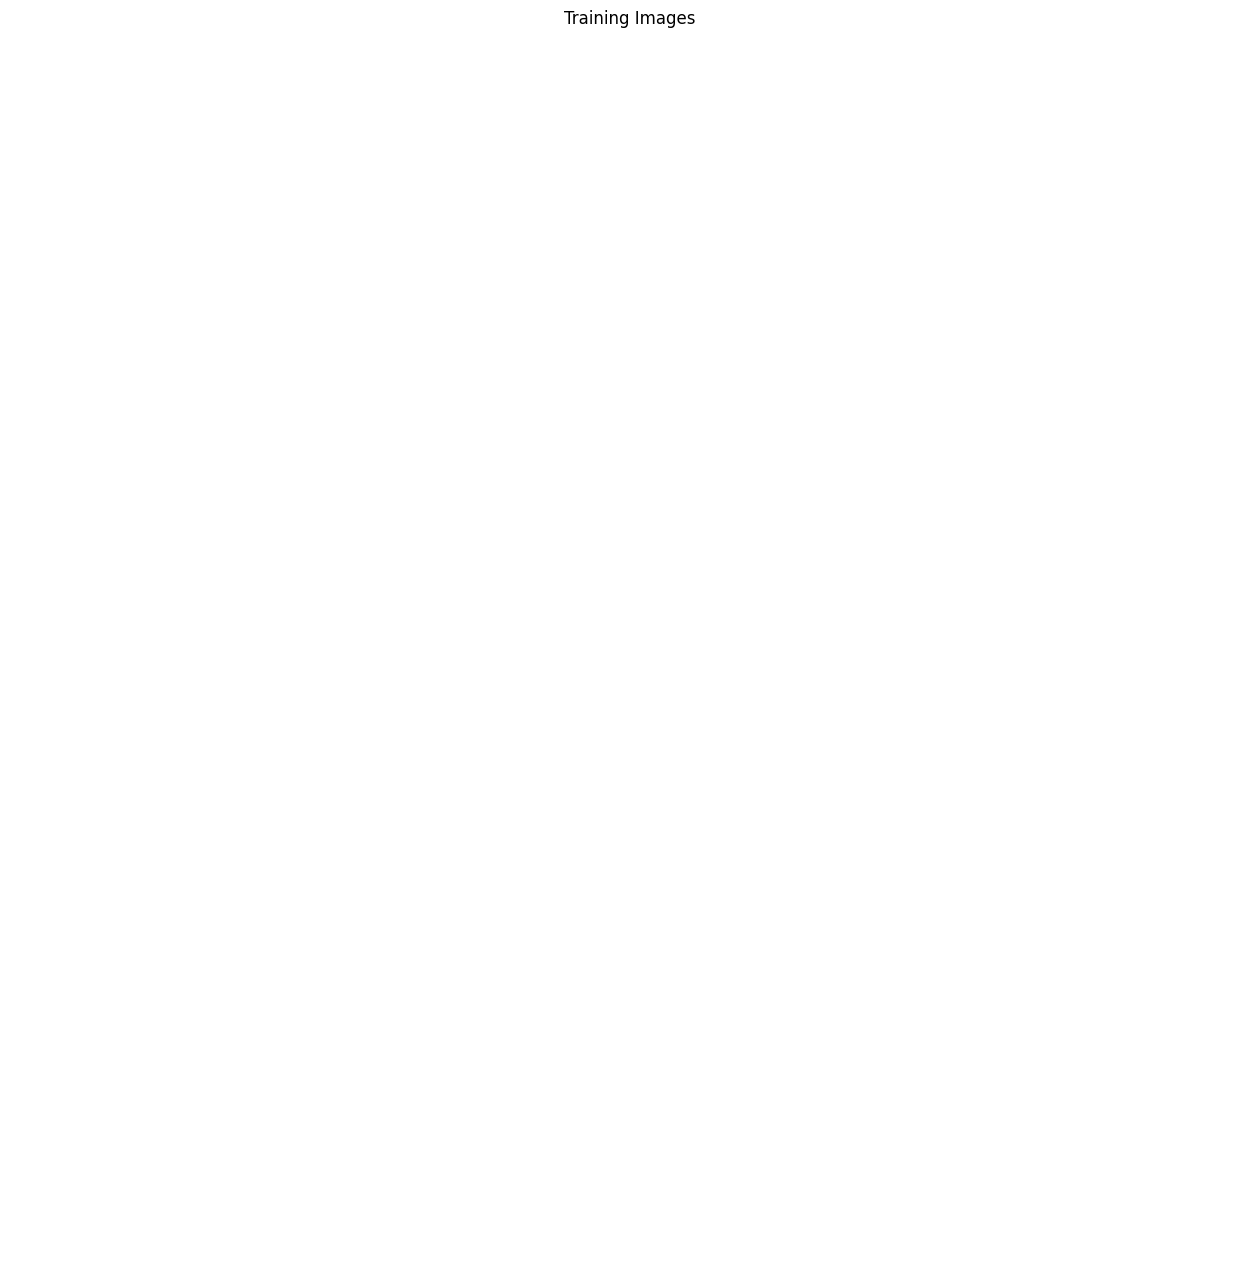

In [12]:
# Decide which device we want to run on
device = torch.device("cuda:7" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(16, 16))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)).numpy())


In [512]:
fpath = 'Sadistic_Music_Factory_screenshots/Sadistic_Music_Factory/Realtime/screenshots/screenshots0000_-1163518185/1002_0_37_533_0000;0010;0000;.png'
fpath1 = 'Sadistic_Music_Factory_screenshots/Sadistic_Music_Factory/Realtime/screenshots/screenshots0000_-1163518185/1005_0_46_552_0000;0000;0010;.png'
fpath2 = 'Sadistic_Music_Factory_screenshots/Sadistic_Music_Factory/Realtime/screenshots/screenshots0000_-1163518185/1008_0_43_567_0000;0010;0010;.png'

In [487]:
img = cv2.imread(fpath, 0)
img1 = cv2.imread(fpath1, 0)
img2 = cv2.imread(fpath2, 0)
merged_img = cv2.merge([img,img1,img2])

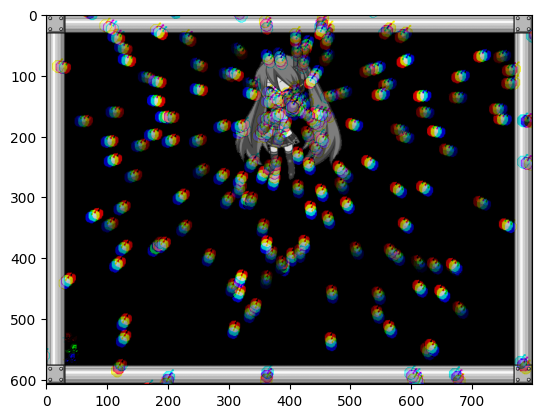

In [382]:
plt.imshow(merged_img, cmap='gray')

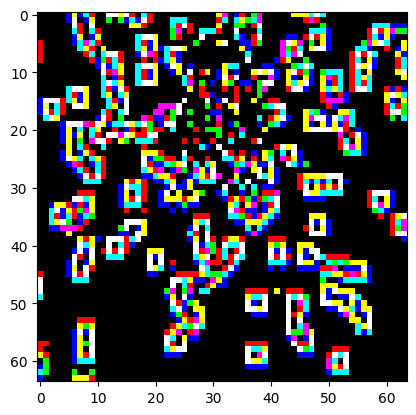

In [384]:
a_s=7
img_edges = fullscreen_transform(cv2.imread(fpath, 0), zero_screenshot=zero_screenshot, aperture_size=a_s)
img1_edges = fullscreen_transform(cv2.imread(fpath1, 0), zero_screenshot=zero_screenshot, aperture_size=a_s)
img2_edges = fullscreen_transform(cv2.imread(fpath2, 0), zero_screenshot=zero_screenshot, aperture_size=a_s)
merged_img_edges = cv2.merge([img_edges,img1_edges,img2_edges])
plt.imshow(merged_img_edges, cmap='gray')

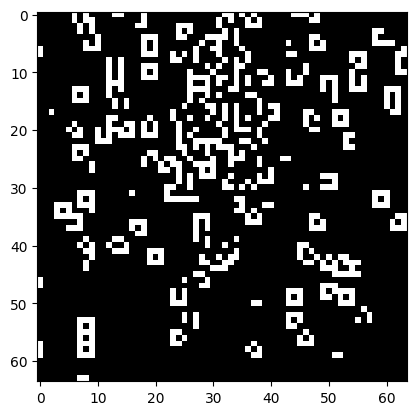

In [358]:
plt.imshow(img_edges, cmap='gray')

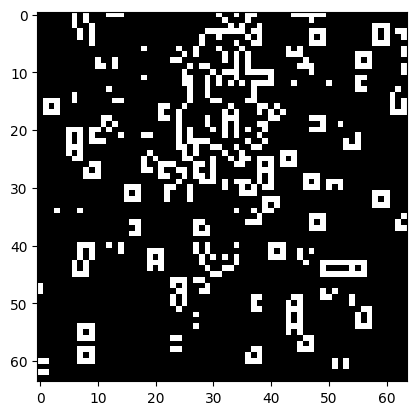

In [359]:
plt.imshow(img1_edges, cmap='gray')

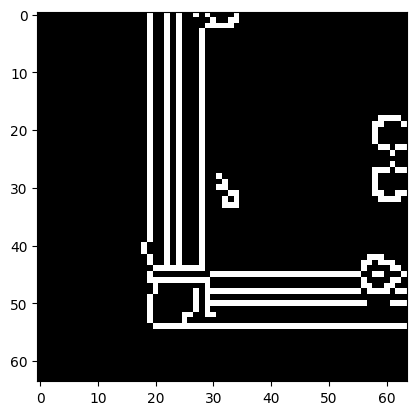

In [312]:
plt.imshow(partscreen_transform(take_screen_part(img, 40, 535, 100, 100, 100)), cmap='gray')

In [174]:
train_ds = ImageFolder(
    root=dataroot,
#     dim=[image_size,image_size]
    transform = transforms.Compose([transforms.CenterCrop([600-64,800-64]),
                               transforms.Resize([image_size,image_size]),
                               transforms.CenterCrop(image_size),
                               transforms.Grayscale(num_output_channels=1),
                               transforms.ToTensor(),])
)

dataloader = DataLoader(train_ds, batch_size, shuffle=True)

In [10]:
train_ds = EdgesDataset(
    root=dataroot,
    dim=[image_size,image_size],
    zero_screenshot=zero_screenshot,
    aperture_size=aperture_size
#     transform = transforms.Compose([transforms.CenterCrop([600-64,800-64]),
#                                transforms.Resize([image_size,image_size]),
#                                transforms.CenterCrop(image_size),
#                                transforms.ToTensor(),])
)

dataloader = DataLoader(train_ds, batch_size, shuffle=True)

In [16]:
var = []
i = 0
for batch in dataloader:
    var.append(torch.var(batch[1]))
    i+=1
    if i > 10:
        print('break')
        break

break


In [17]:
# data_variance = 0.03357546404004097

In [18]:
data_variance  = sum(var) / len(var)
data_variance = data_variance.item()
data_variance

0.05725772678852081

In [19]:
true_percent = []
i = 0
for batch in dataloader:
    
    true_percent.append(torch.count_nonzero(batch[1]) / image_size ** 2 / batch_size)
    i+=1
    if i > 10:
        print('break')
        break

break


In [20]:
true_percentage  = sum(true_percent) / len(true_percent)
true_percentage = true_percentage.item()
true_percentage

0.12387102097272873

In [480]:
# Decide which device we want to run on
device = torch.device("cuda:7" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(16, 16))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)).numpy())


cuda:8
SMF_screenshots_enriched/screenshots/screenshots0000_1144804095/6090.png SMF_screenshots_enriched/screenshots_add/screenshots0000_1144804095/6090.png
<class 'tuple'>


error: OpenCV(4.7.0) :-1: error: (-5:Bad argument) in function 'merge'
> Overload resolution failed:
>  - Can't parse 'mv'. Sequence item with index 0 has a wrong type
>  - Can't parse 'mv'. Sequence item with index 0 has a wrong type


In [25]:
next(iter(dataloader))[0].shape

torch.Size([256, 2, 64, 64])

In [26]:
def calc_same_pad(i: int, k: int, s: int, d: int) -> int:
    return max((math.ceil(i / s) - 1) * s + (k - 1) * d + 1 - i, 0)

class Conv2dSame(torch.nn.Conv2d):

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
#         print(x.size())
        ih, iw = x.size()[-2:]

        pad_h = calc_same_pad(i=ih, k=self.kernel_size[0], s=self.stride[0], d=self.dilation[0])
        pad_w = calc_same_pad(i=iw, k=self.kernel_size[1], s=self.stride[1], d=self.dilation[1])
        
        if pad_h > 0 or pad_w > 0:
            x = F.pad(
                x, [pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2]
            )
            
        x = F.conv2d(
            x,
            self.weight,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
        )
        
        return x
    
class ConvTranspose2dSame(torch.nn.ConvTranspose2d):

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        ih, iw = x.size()[-2:]
        ih *= 2
        iw *= 2

        pad_h = calc_same_pad(i=ih, k=self.kernel_size[0], s=self.stride[0], d=self.dilation[0])
        pad_w = calc_same_pad(i=iw, k=self.kernel_size[1], s=self.stride[1], d=self.dilation[1])
        
        x = F.conv_transpose2d(
            x,
            self.weight,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
        )
        
        if pad_h > 0 or pad_w > 0:
            x = F.pad(
                x, list(map(lambda x: -x * self.stride[0], [pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2]))
            )
            
        return x

In [27]:
def power_calc(number, base):
    power = 0
    
    if (number < 1):
        raise ValueError(f'not power of {base}')
        
    while (number != 1):
            if (number % base != 0):
                raise ValueError(f'not power of {base}')
            number = number // base
            power += 1
             
    return power

In [28]:
power_calc(128,2)

7

In [29]:
list(reversed(np.arange(1,4)))

[3, 2, 1]

In [30]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, embedding_dim, image_size, embedding_image_size):
        super(Encoder, self).__init__()
        
        num_of_convs = power_calc(image_size,2) - power_calc(embedding_image_size,2)
        
        conv_layers = [Conv2dSame(in_channels=in_channels,
                                 out_channels=num_hiddens // 2**(num_of_convs - 1),
                                 kernel_size=3,
                                 stride=2), 
                       nn.BatchNorm2d(num_hiddens // 2**(num_of_convs - 1)),
                       nn.LeakyReLU()]
        
        for i in reversed(range(1, num_of_convs)):
            conv_layers.append(Conv2dSame(in_channels=num_hiddens//2**(i),
                                 out_channels=num_hiddens//2**(i-1),
                                 kernel_size=3,
                                 stride=2))
            conv_layers.append(nn.BatchNorm2d(num_hiddens//2**(i-1)))
            conv_layers.append(nn.LeakyReLU())

        self._convs = nn.Sequential(*conv_layers)
        
        if num_hiddens != embedding_dim:
            self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens, 
                                          out_channels=embedding_dim,
                                          kernel_size=1, 
                                          stride=1)

    def forward(self, x):
        
        x = self._convs(x)
        
        if num_hiddens != embedding_dim:
            x = self._pre_vq_conv(x)
        
        return x

In [33]:
encoder = Encoder(in_channels, num_hiddens, embedding_dim, image_size, embedding_image_size).to(device)

In [34]:
summary(encoder, (in_channels, image_size, image_size))

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cuda:7! (when checking argument for argument weight in method wrapper__cudnn_convolution)

In [35]:
class Decoder(nn.Module):
    def __init__(self, out_channels, num_hiddens, embedding_dim,  image_size, embedding_image_size):
        super(Decoder, self).__init__()
        
        if num_hiddens != embedding_dim:
            self.posq_vq_conv = nn.Conv2d(in_channels=embedding_dim,
                                     out_channels=num_hiddens,
                                     kernel_size=1, 
                                     stride=1)
        
        num_of_convs_transes = power_calc(image_size,2) - power_calc(embedding_image_size,2)
        
        conv_trans_layers = [ConvTranspose2dSame(in_channels=num_hiddens,
                                 out_channels=num_hiddens // 2,
                                 kernel_size=3,
                                 stride=2), 
                             nn.BatchNorm2d(num_hiddens // 2),
                             nn.LeakyReLU()]
        
        for i in range(power_calc(embedding_image_size,2), power_calc(image_size,2) - 1):
            
            if i != power_calc(image_size,2) - 2:
                conv_trans_layers.append(ConvTranspose2dSame(in_channels=num_hiddens//2**(i-1-power_calc(embedding_image_size,2)+2),
                                 out_channels=num_hiddens//2**(i-power_calc(embedding_image_size,2)+2),
                                 kernel_size=3,
                                 stride=2))
                conv_trans_layers.append(nn.BatchNorm2d(num_hiddens//2**(i-power_calc(embedding_image_size,2)+2)))
                conv_trans_layers.append(nn.LeakyReLU())
            else:
                conv_trans_layers.append(ConvTranspose2dSame(in_channels=num_hiddens//2**(i-1-power_calc(embedding_image_size,2)+2),
                                 out_channels=out_channels,
                                 kernel_size=3,
                                 stride=2))
                conv_trans_layers.append(nn.Sigmoid())

        self._conv_transes = nn.Sequential(*conv_trans_layers)

    def forward(self, x):
        
        if num_hiddens != embedding_dim:
            x = self.posq_vq_conv(x)
        
        x = self._conv_transes(x)
        
        return x

In [36]:
decoder = Decoder(in_channels, num_hiddens, 
                                embedding_dim,  image_size, embedding_image_size).to(device)

In [421]:
summary(decoder, (embedding_dim, embedding_image_size, embedding_image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
ConvTranspose2dSame-1             [-1, 64, 8, 8]          73,792
       BatchNorm2d-2             [-1, 64, 8, 8]             128
         LeakyReLU-3             [-1, 64, 8, 8]               0
ConvTranspose2dSame-4           [-1, 32, 16, 16]          18,464
       BatchNorm2d-5           [-1, 32, 16, 16]              64
         LeakyReLU-6           [-1, 32, 16, 16]               0
ConvTranspose2dSame-7           [-1, 16, 32, 32]           4,624
       BatchNorm2d-8           [-1, 16, 32, 32]              32
         LeakyReLU-9           [-1, 16, 32, 32]               0
ConvTranspose2dSame-10            [-1, 1, 64, 64]             145
          Sigmoid-11            [-1, 1, 64, 64]               0
Total params: 97,249
Trainable params: 97,249
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forwa

In [37]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, vq_coef):
        super(VectorQuantizer, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost
        self._vq_coef = vq_coef

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = self._vq_coef * q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

In [38]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, vq_coef, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost
        self._vq_coef = vq_coef
        
        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()
        
        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
#         print(inputs.size())
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)
            
            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)
            
            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)
            
            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))
        
        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        vq_loss = F.mse_loss(quantized, inputs.detach())
#         print(quantized.shape,inputs.shape)
        
        loss = self._vq_coef * vq_loss + self._commitment_cost * e_latent_loss 
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encoding_indices

In [39]:
class EdgeDetectionLoss(nn.Module):
    def __init__(self, w1, w2, w3, data_variance):
        super(EdgeDetectionLoss, self).__init__()
        self.w1 = w1
        self.w2 = w2
        self.w3 = w3
        self.data_variance = data_variance

    def forward(self, output, target):
        loss = -target*output *self.w1 + target*(1-output) *self.w2 + output*(1-target)*self.w3
        return loss.mean() / data_variance

edge_loss = EdgeDetectionLoss(w1=1, w2=0.01, w3=0.01, data_variance=data_variance*4)

In [40]:
class EdgeDetectionEntropyLoss(nn.Module):
    def __init__(self, true_percentage):
        super(EdgeDetectionEntropyLoss, self).__init__()
        self.true_percentage = true_percentage

    def forward(self, output, target):
        loss = (1 - self.true_percentage) * target * torch.log(output)\
        + self.true_percentage * (1 - target) * torch.log(1 - output)
        return - loss.mean()

edge_loss = EdgeDetectionEntropyLoss(true_percentage)

In [41]:
class EdgeDetectionEntropyLossZeroScreenshot(nn.Module):
    def __init__(self, true_percentage, zero_screenshot_tensor):
        super(EdgeDetectionEntropyLoss, self).__init__()
        self.true_percentage = true_percentage
        self.zero_screenshot_tensor = zero_screenshot_tensor

    def forward(self, output, target):
        loss = (1 - self.true_percentage) * target * torch.log(output)\
        + self.true_percentage * (1 - target) * torch.log(1 - output)
#         print(loss.shape)
#         print((output != zero_screenshot_tensor).shape)
        loss *= (target != self.zero_screenshot_tensor)
#         print(loss.shape)
        return - loss.mean()

edge_loss = EdgeDetectionEntropyLoss(true_percentage, zero_screenshot_tensor)

TypeError: __init__() takes 2 positional arguments but 3 were given

In [42]:
class VQ_VAE(nn.Module):
    def __init__(self, num_channels, num_hiddens, 
                 num_embeddings, embedding_dim, image_size, embedding_image_size, commitment_cost, vq_coef, decay=0):
        super(VQ_VAE, self).__init__()
        
        self._encoder = Encoder(num_channels, num_hiddens,
                                embedding_dim, image_size, embedding_image_size,)
        
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens, 
                                      out_channels=embedding_dim,
                                      kernel_size=1, 
                                      stride=1)
        
        if decay > 0: 
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim, 
                                              commitment_cost, vq_coef, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim, 
                                              commitment_cost, vq_coef)
        
        self._decoder = Decoder(num_channels, num_hiddens, 
                                embedding_dim,  image_size, embedding_image_size)

    def forward(self, x):
        z = self._encoder(x)
        loss, quantized, perplexity, _ = self._vq_vae(z)
#         print(quantized.shape)
        x_recon = self._decoder(quantized)
#         print(x_recon.shape)

        return loss, x_recon, perplexity

In [196]:
entropy_loss = nn.CrossEntropyLoss()

In [197]:
model = VQ_VAE(num_channels, num_hiddens, num_embeddings, embedding_dim, image_size, embedding_image_size, commitment_cost, vq_coef, decay).to(device)

In [198]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

In [44]:
class VanillaVAE(nn.Module):
    def __init__(self, in_channels, num_hiddens, image_size, embedding_image_size,
                 embedding_dim, true_percentage):
        super(VanillaVAE, self).__init__()
        
        self.num_hiddens = num_hiddens
        self.embedding_dim = embedding_dim
            
        self.encoder = Encoder(in_channels, num_hiddens, embedding_dim, image_size, embedding_image_size)
        self.decoder = Decoder(in_channels, num_hiddens, embedding_dim,  image_size, embedding_image_size)
        self.fc_mu = nn.Linear(num_hiddens*embedding_image_size**2, embedding_dim)
        self.fc_var = nn.Linear(num_hiddens*embedding_image_size**2, embedding_dim)
        
        self.decoder_input = nn.Linear(embedding_dim, num_hiddens*embedding_image_size**2)
        
        self.loss = EdgeDetectionEntropyLoss(true_percentage)
        
    def encode(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)
        
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        
        return [mu, log_var]
    
    def decode(self, z):
        z = self.decoder_input(z)
        z = z.view(-1, num_hiddens, embedding_image_size, embedding_image_size)
        z = self.decoder(z)
        return z
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu
    
    def forward(self, x, **kwargs):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return [self.decode(z), x, mu, log_var]
    
    @abstractmethod
    def loss_f(self, *args, **kwargs):
        output = args[0]
        target = args[1]
        mu = args[2]
        log_var = args[3]
        
        entropy_weight = kwargs['ENTROPY_W']
        
        kld_weight = kwargs['M_N']
        
        recons_loss = self.loss(output, target)
        
        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim=1), dim = 0)
        
        loss = entropy_weight * recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss': recons_loss.detach(), 'KLD': -kld_loss.detach()}
    
    def sample (self, num_samples, current_device):
        z = torch.randn(num_samples, self.latent_dim)
        z = z.to(current_device)
        samples = self.decode(z)    
        return samples
    
    def generate(self, x, **kwargs):
        return self.forward(x)[0]

In [45]:
# device = torch.device('cuda:8' if torch.cuda.is_available() else 'cpu')
model = VanillaVAE(in_channels, num_hiddens, image_size, embedding_image_size,
                 embedding_dim, 0.5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

In [ ]:
summary(model, (in_channels, image_size, image_size))

In [47]:
model.train()
train_res_recon_error = []
train_res_vq_loss = []
train_res_perplexity = []

count = 0
train_res_KLD = []

In [48]:
def show_images(model, dataloader):
    iter_dl = iter(dataloader)
    x = next(iter_dl)
    x = x[1]
    # _, data_recon, _ = model(x.to(device))
    data_recon, _, _, _ = model(x.to(device))

    fig = plt.figure(figsize=(25, 16))
    for i in np.arange(0,16):

        ax = fig.add_subplot(4, 8, i*2 + 1, xticks=[], yticks=[])
        img = x[i].numpy().transpose(1,2,0)
        if img.shape[2] == 2:
            img = np.concatenate([img,np.expand_dims(img[:,:,1],axis=2)],axis=2)
        plt.imshow(img)
        
        ax = fig.add_subplot(4, 8, i*2 + 2, xticks=[], yticks=[])
        img = (data_recon[i].cpu().detach().numpy().transpose(1,2,0))
        if img.shape[2] == 2:
            img = np.concatenate([img,np.expand_dims(img[:,:,1],axis=2)],axis=2)
        plt.imshow(img)

/tmp/ipykernel_868/1058866582.py:2: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


525 iterations
recon_error: 0.074
KLD: -19.282

550 iterations
recon_error: 0.072
KLD: -19.975

575 iterations
recon_error: 0.070
KLD: -20.621

600 iterations
recon_error: 0.068
KLD: -21.285

625 iterations
recon_error: 0.067
KLD: -21.904

650 iterations
recon_error: 0.065
KLD: -22.444

675 iterations
recon_error: 0.063
KLD: -23.002

700 iterations
recon_error: 0.061
KLD: -23.492

725 iterations
recon_error: 0.060
KLD: -24.012

750 iterations
recon_error: 0.059
KLD: -24.545

775 iterations
recon_error: 0.058
KLD: -25.000

800 iterations
recon_error: 0.057
KLD: -25.412

825 iterations
recon_error: 0.056
KLD: -25.782

850 iterations
recon_error: 0.055
KLD: -26.158

875 iterations
recon_error: 0.055
KLD: -26.462

900 iterations
recon_error: 0.054
KLD: -26.789

925 iterations
recon_error: 0.053
KLD: -27.056

950 iterations
recon_error: 0.053
KLD: -27.323

975 iterations
recon_error: 0.052
KLD: -27.645

1000 iterations
recon_error: 0.052
KLD: -27.912

1025 iterations
recon_error: 0.052
KLD:

/usr/local/lib/python3.8/dist-packages/torch/autograd/__init__.py:197: UserWarning: Error detected in LogBackward0. Traceback of forward call that caused the error:
  File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 1041, in launch_instance
    app.start()
  File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 724, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 215, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
    self._run_once()
  File "/usr/lib/python3.8/asyncio

RuntimeError: Function 'LogBackward0' returned nan values in its 0th output.

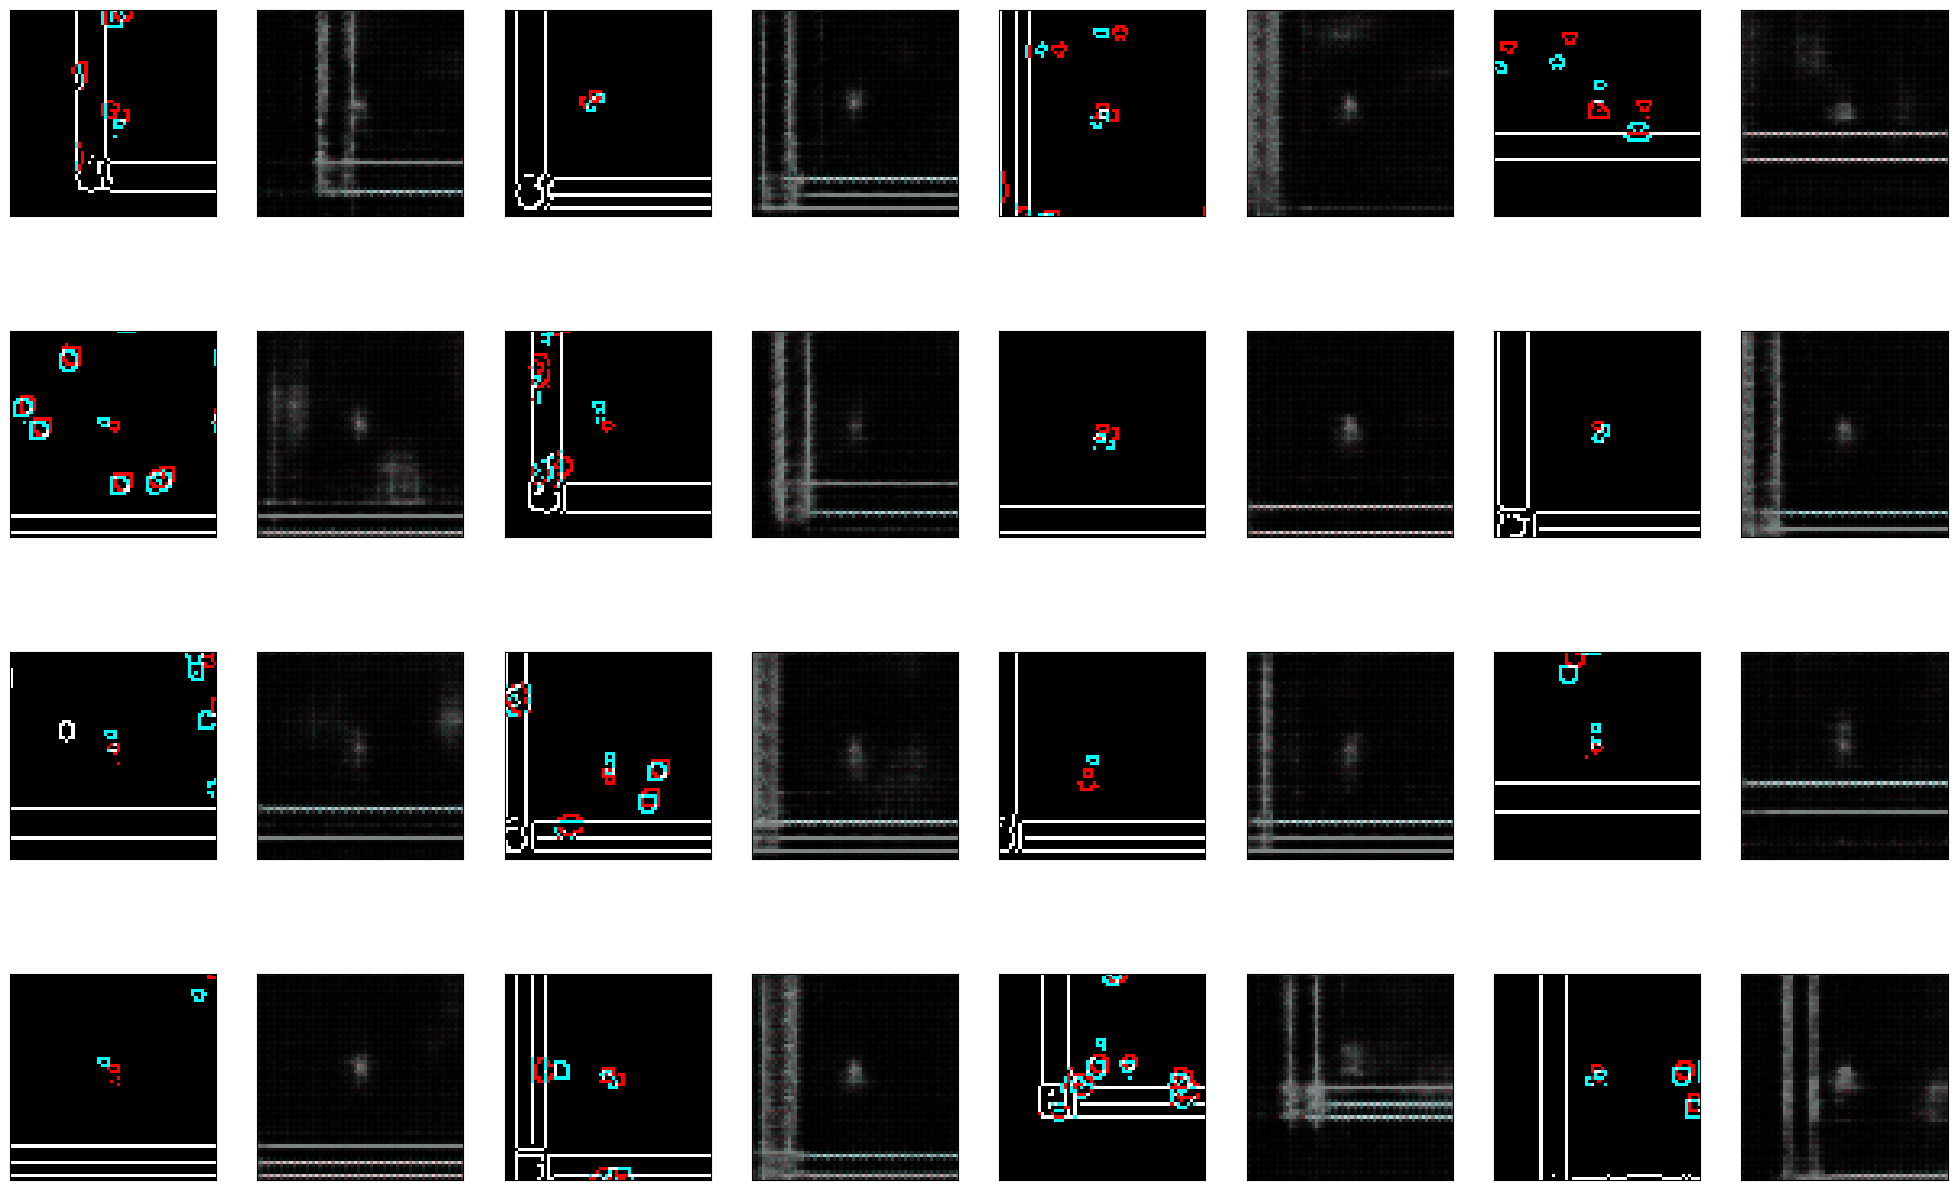

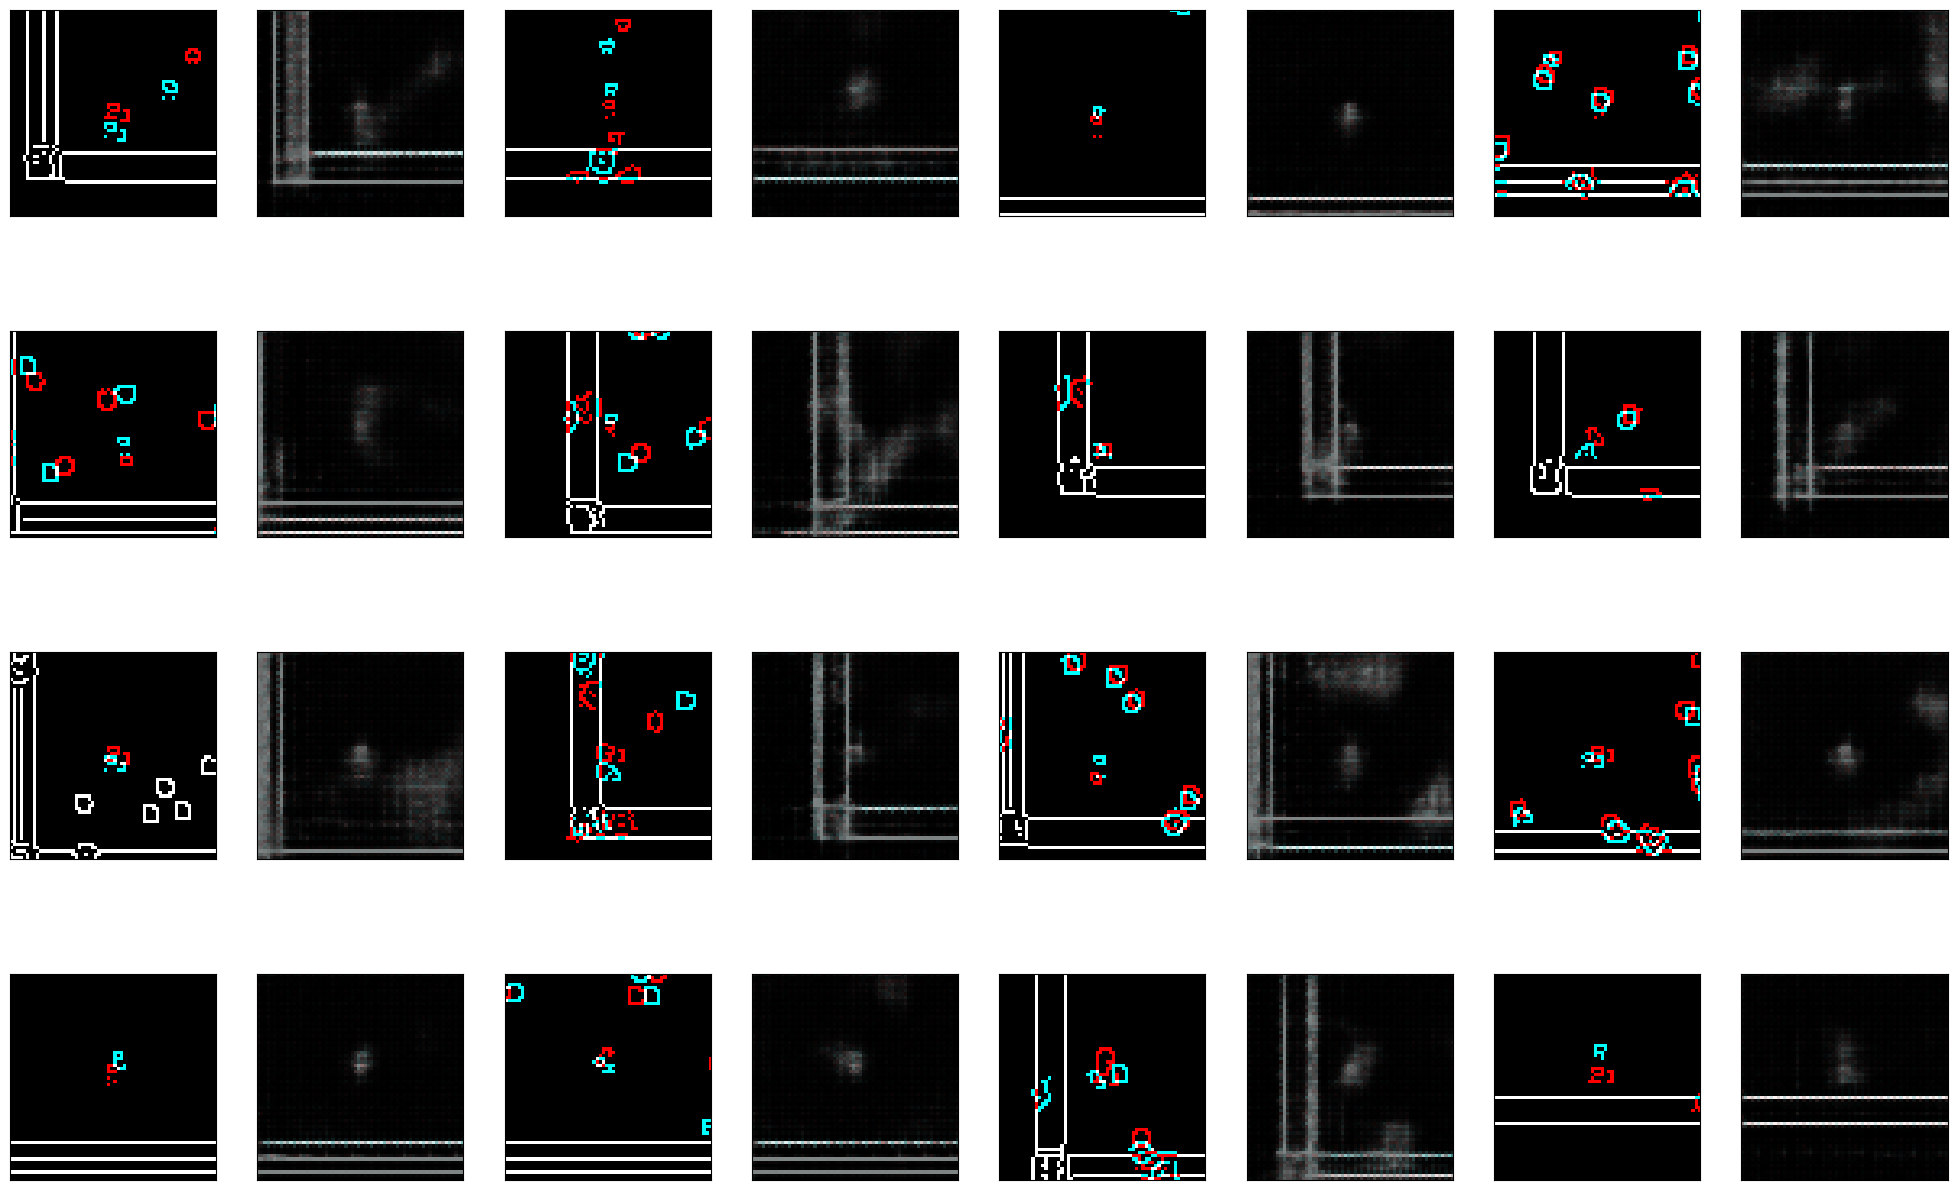

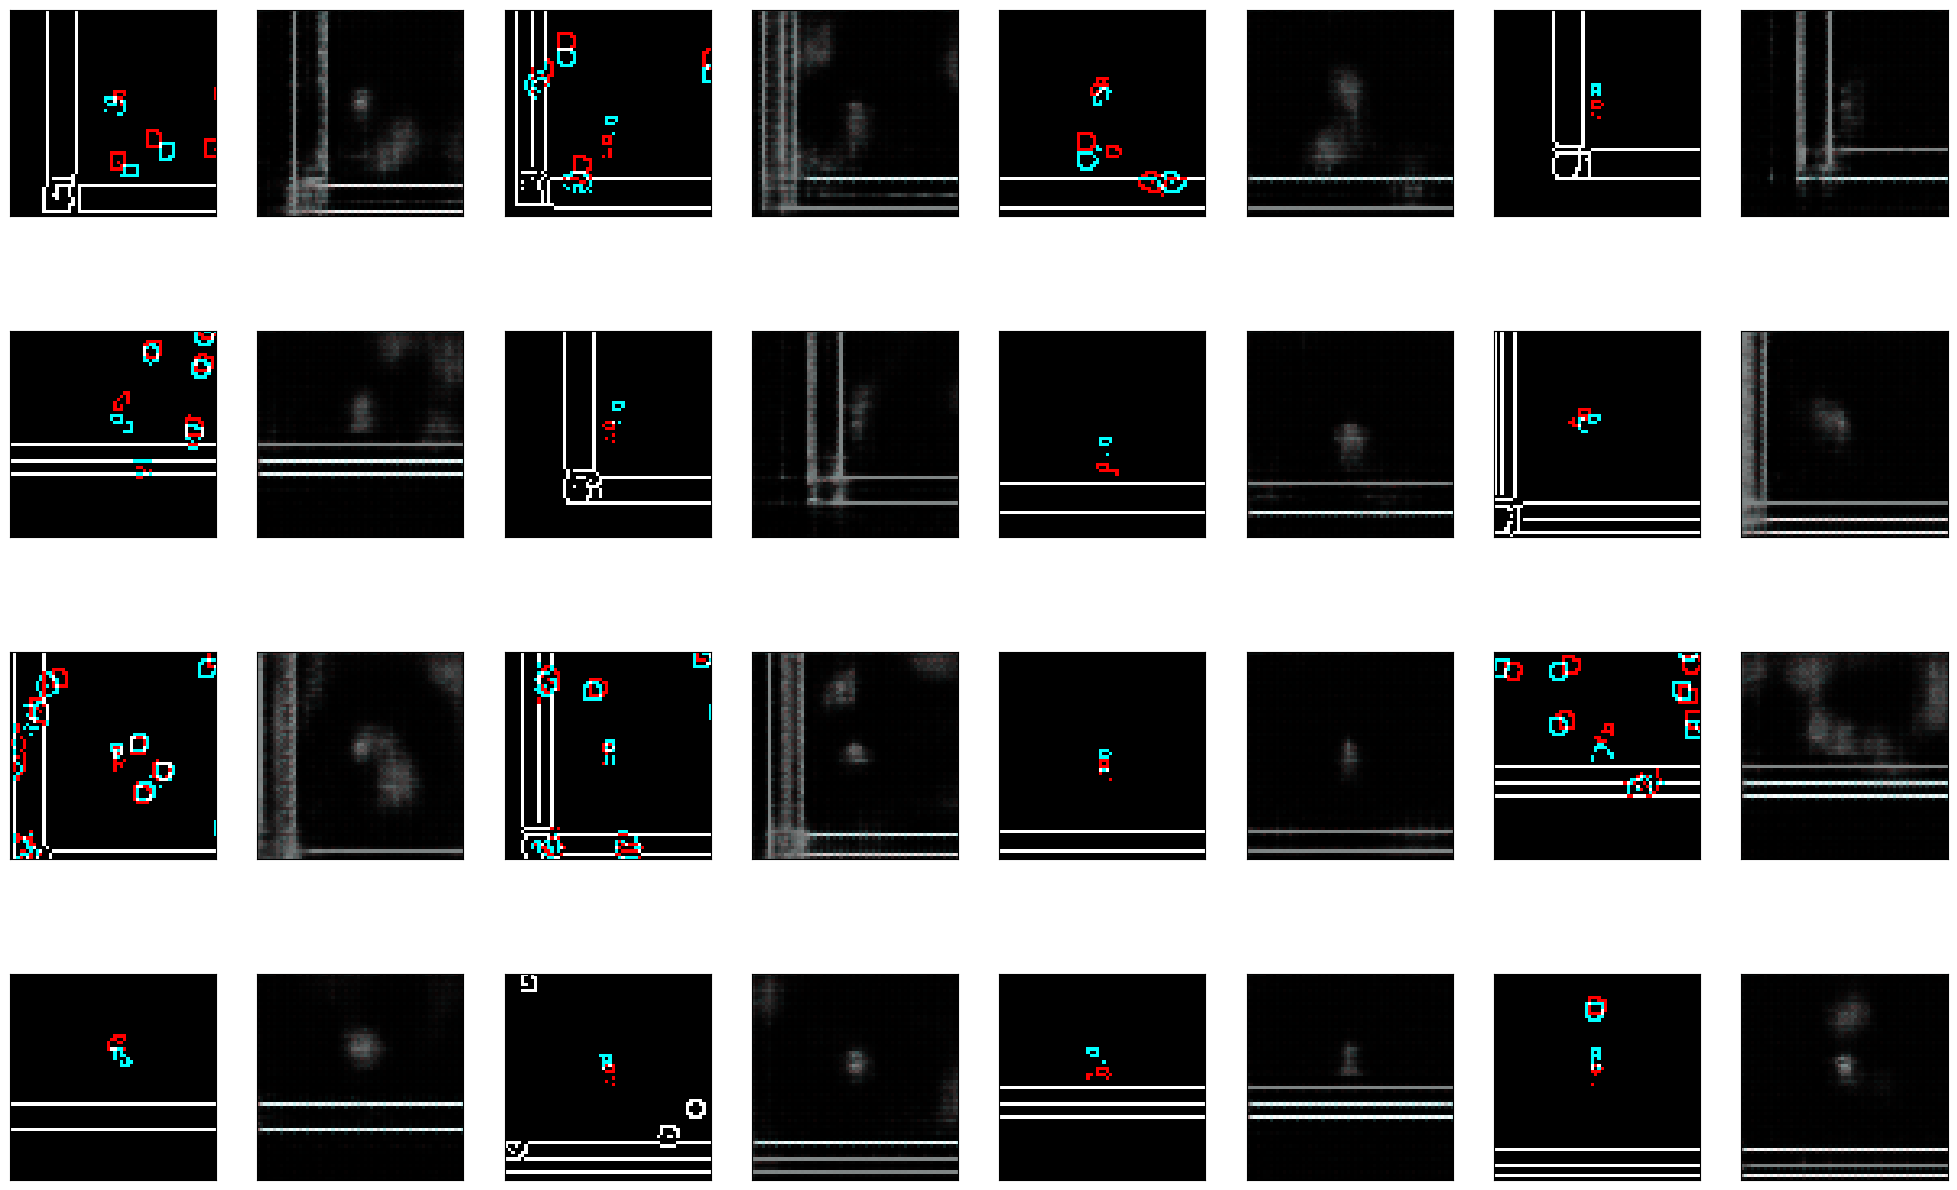

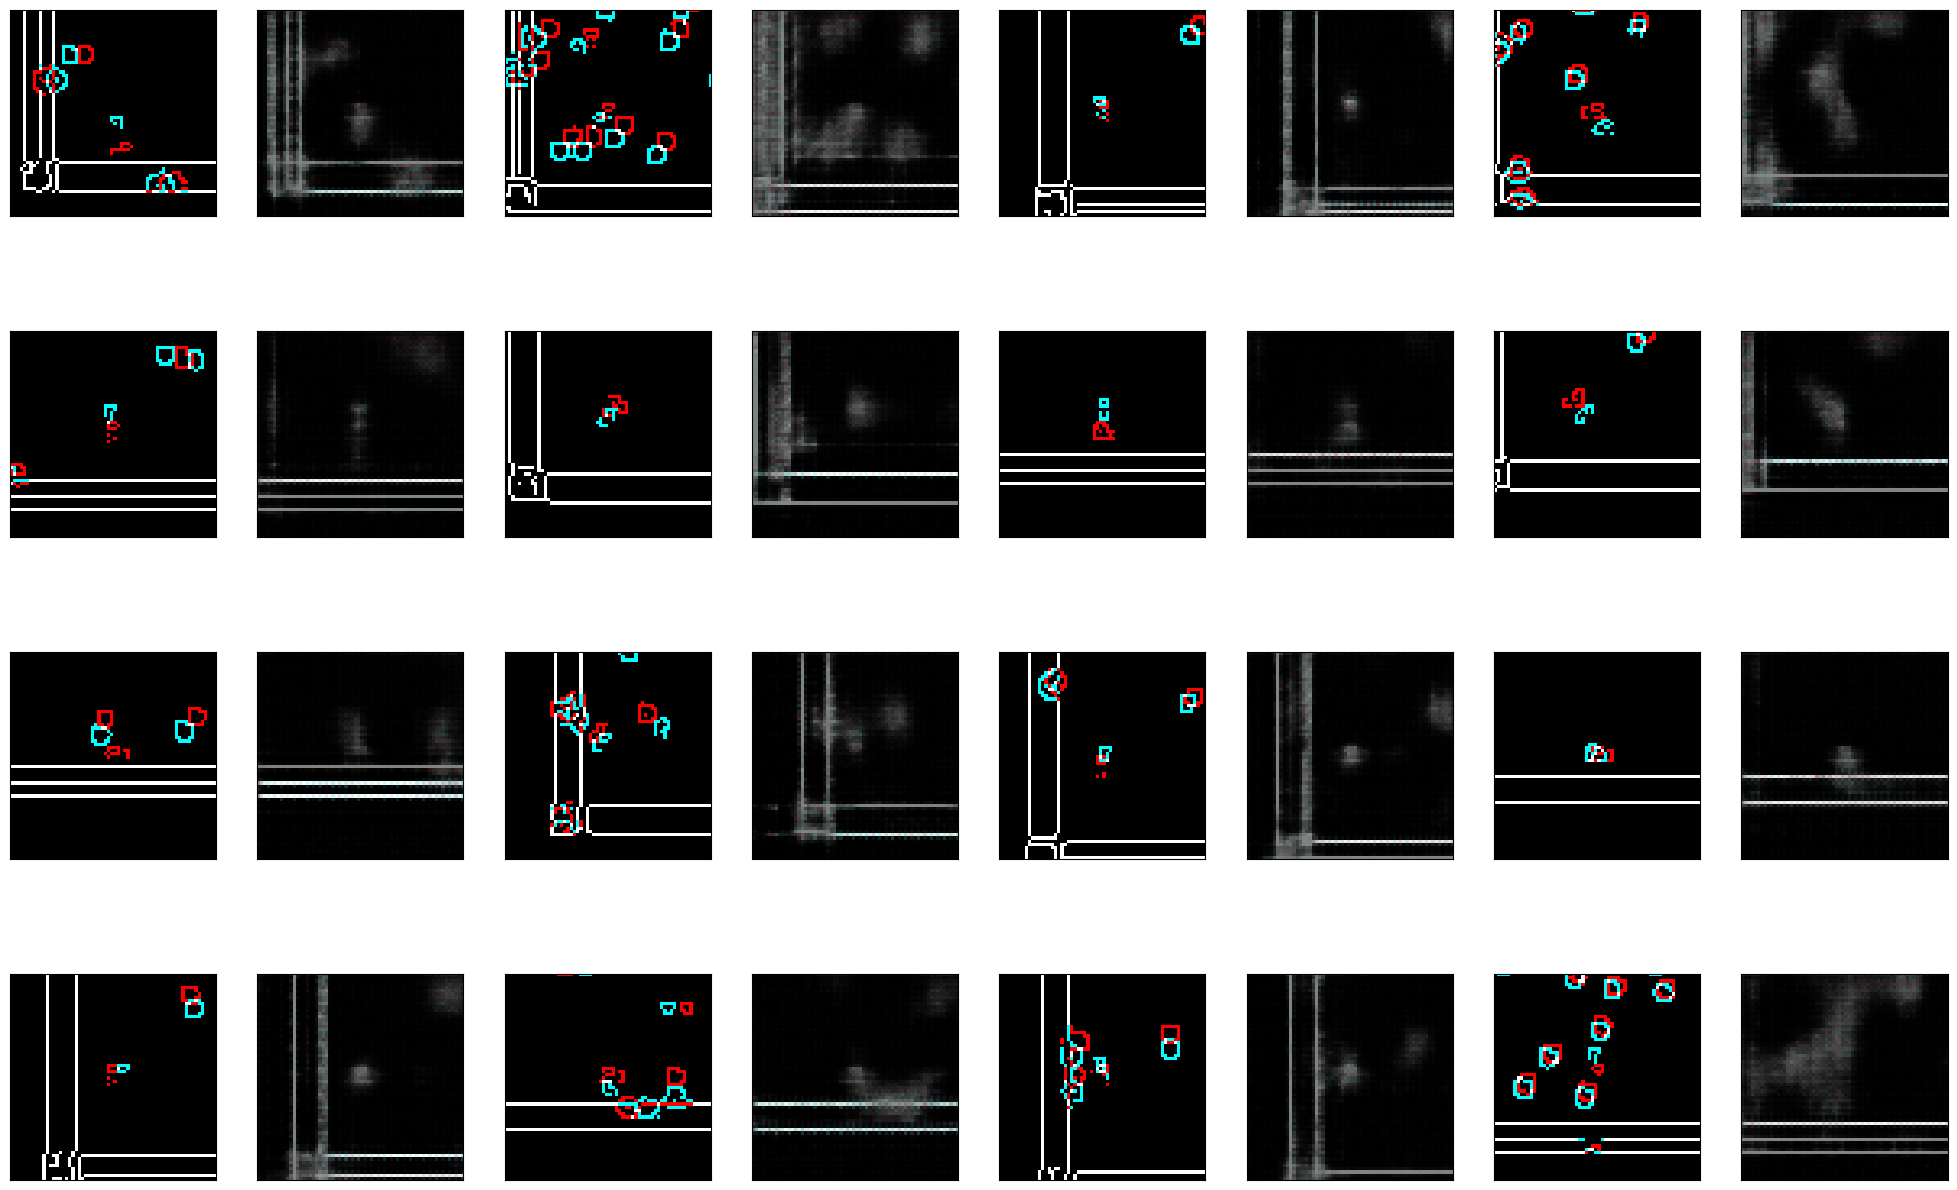

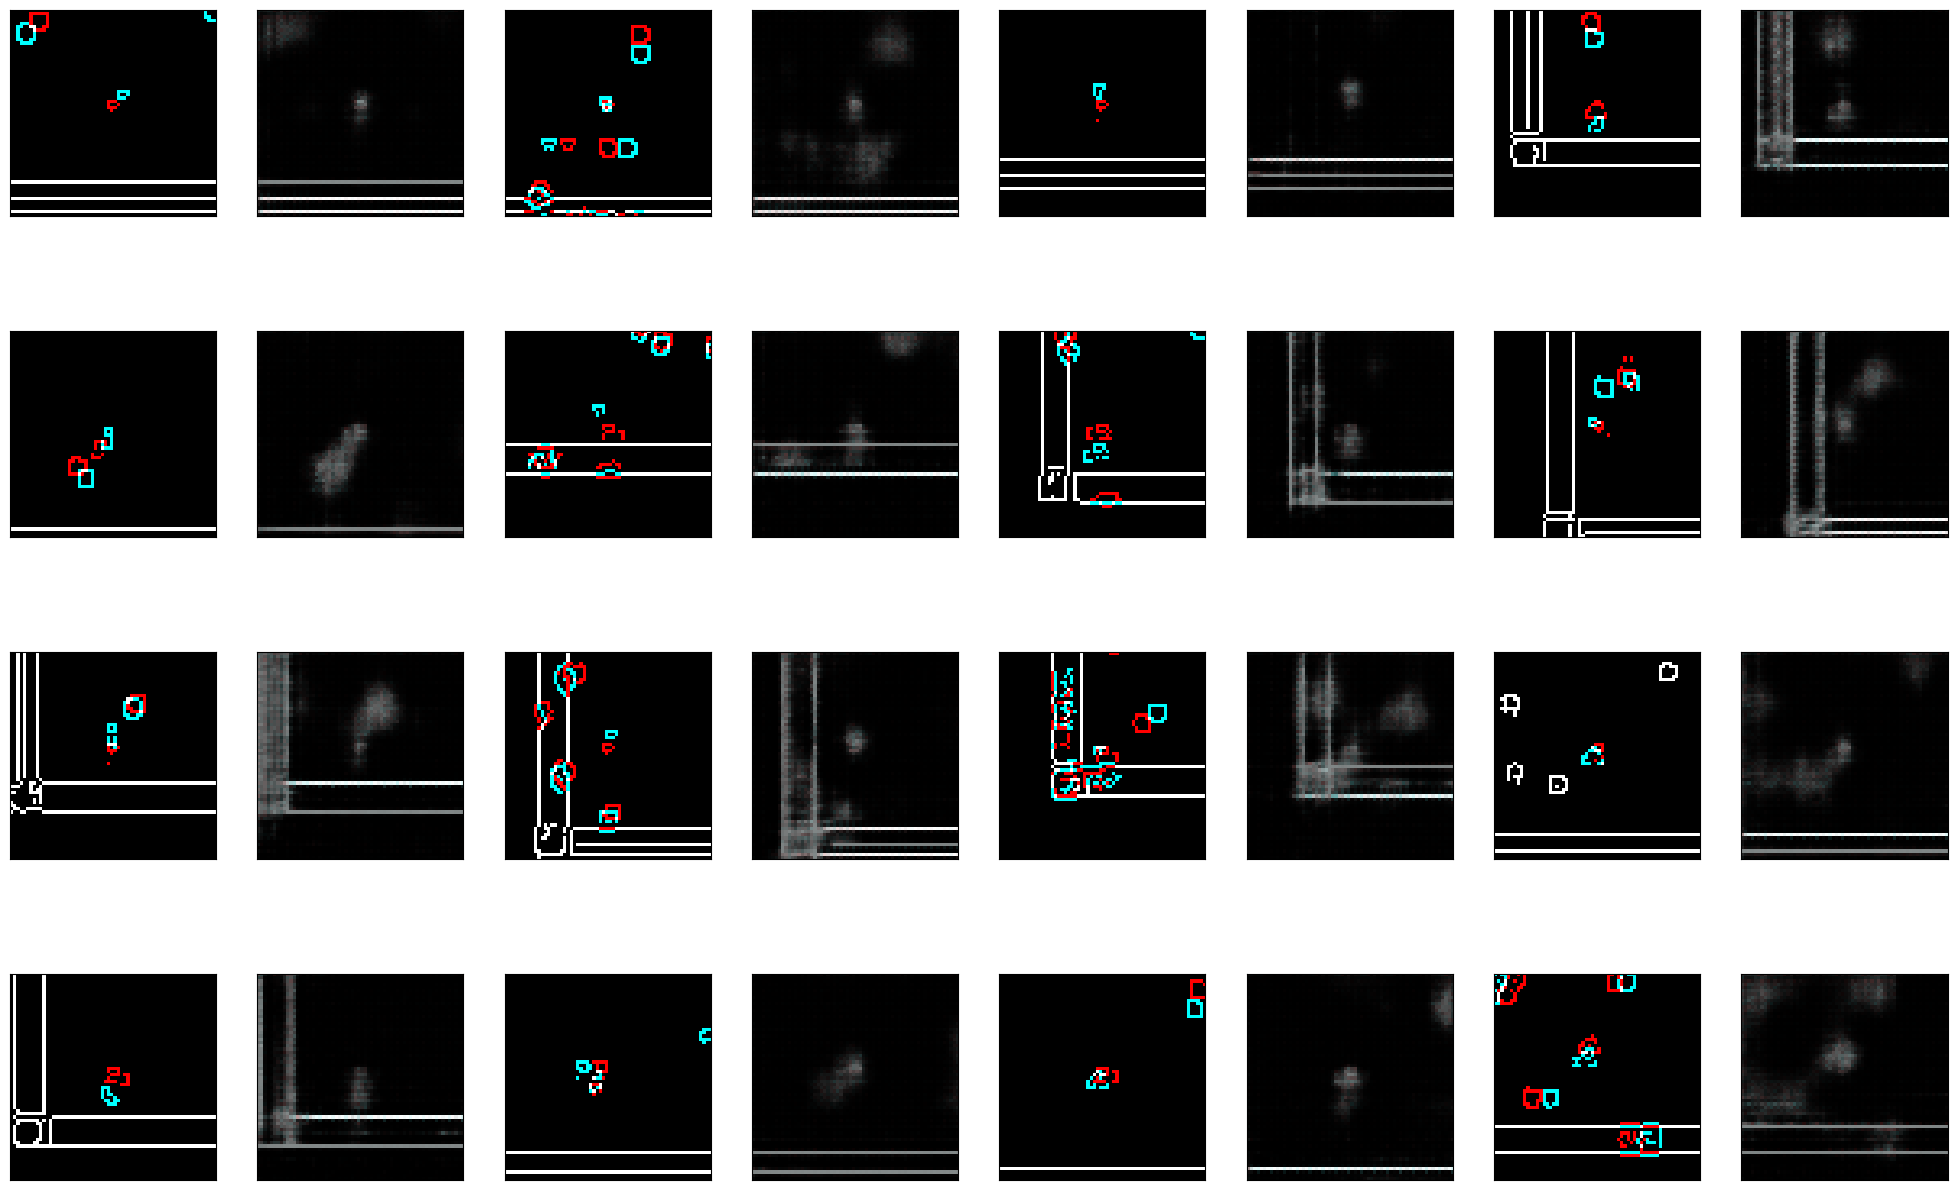

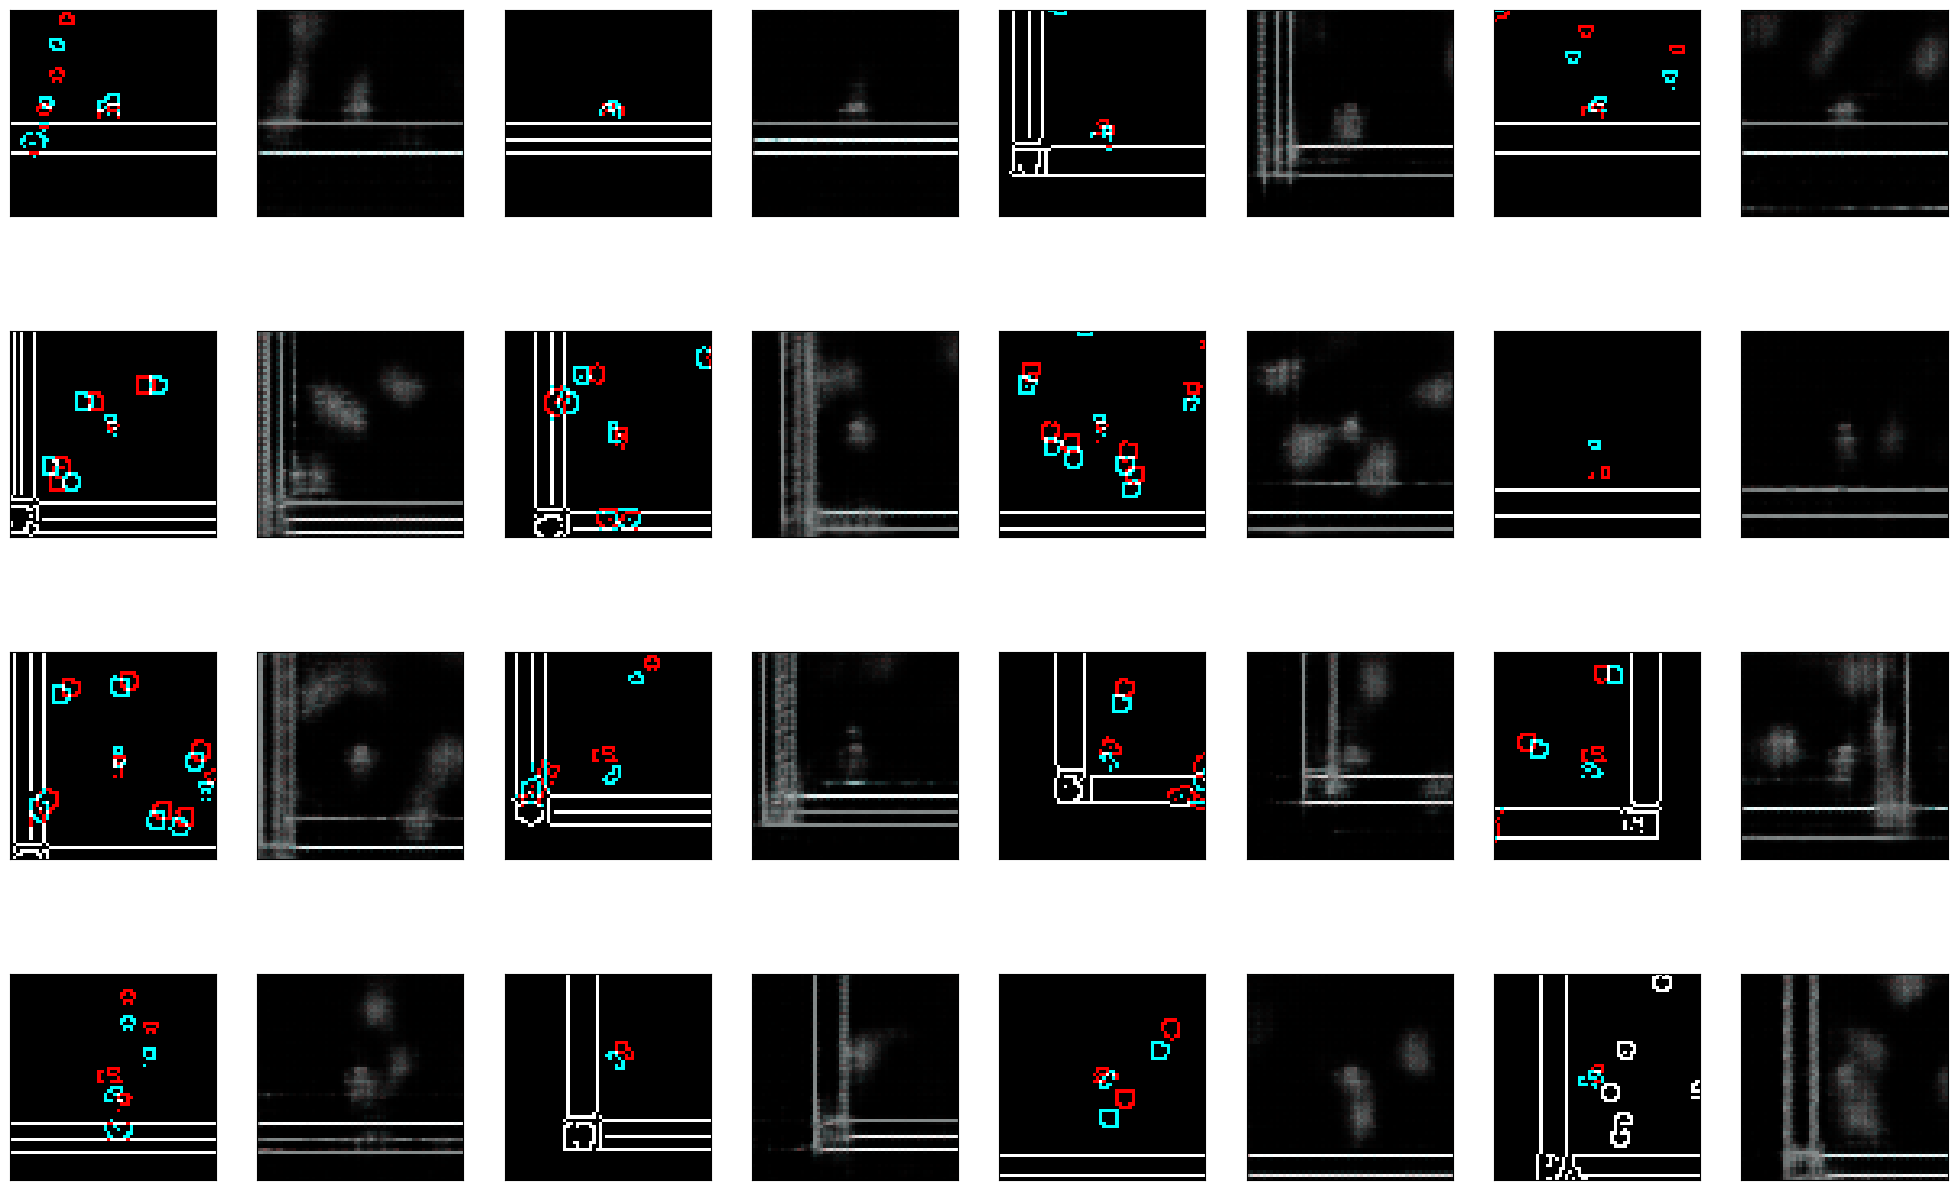

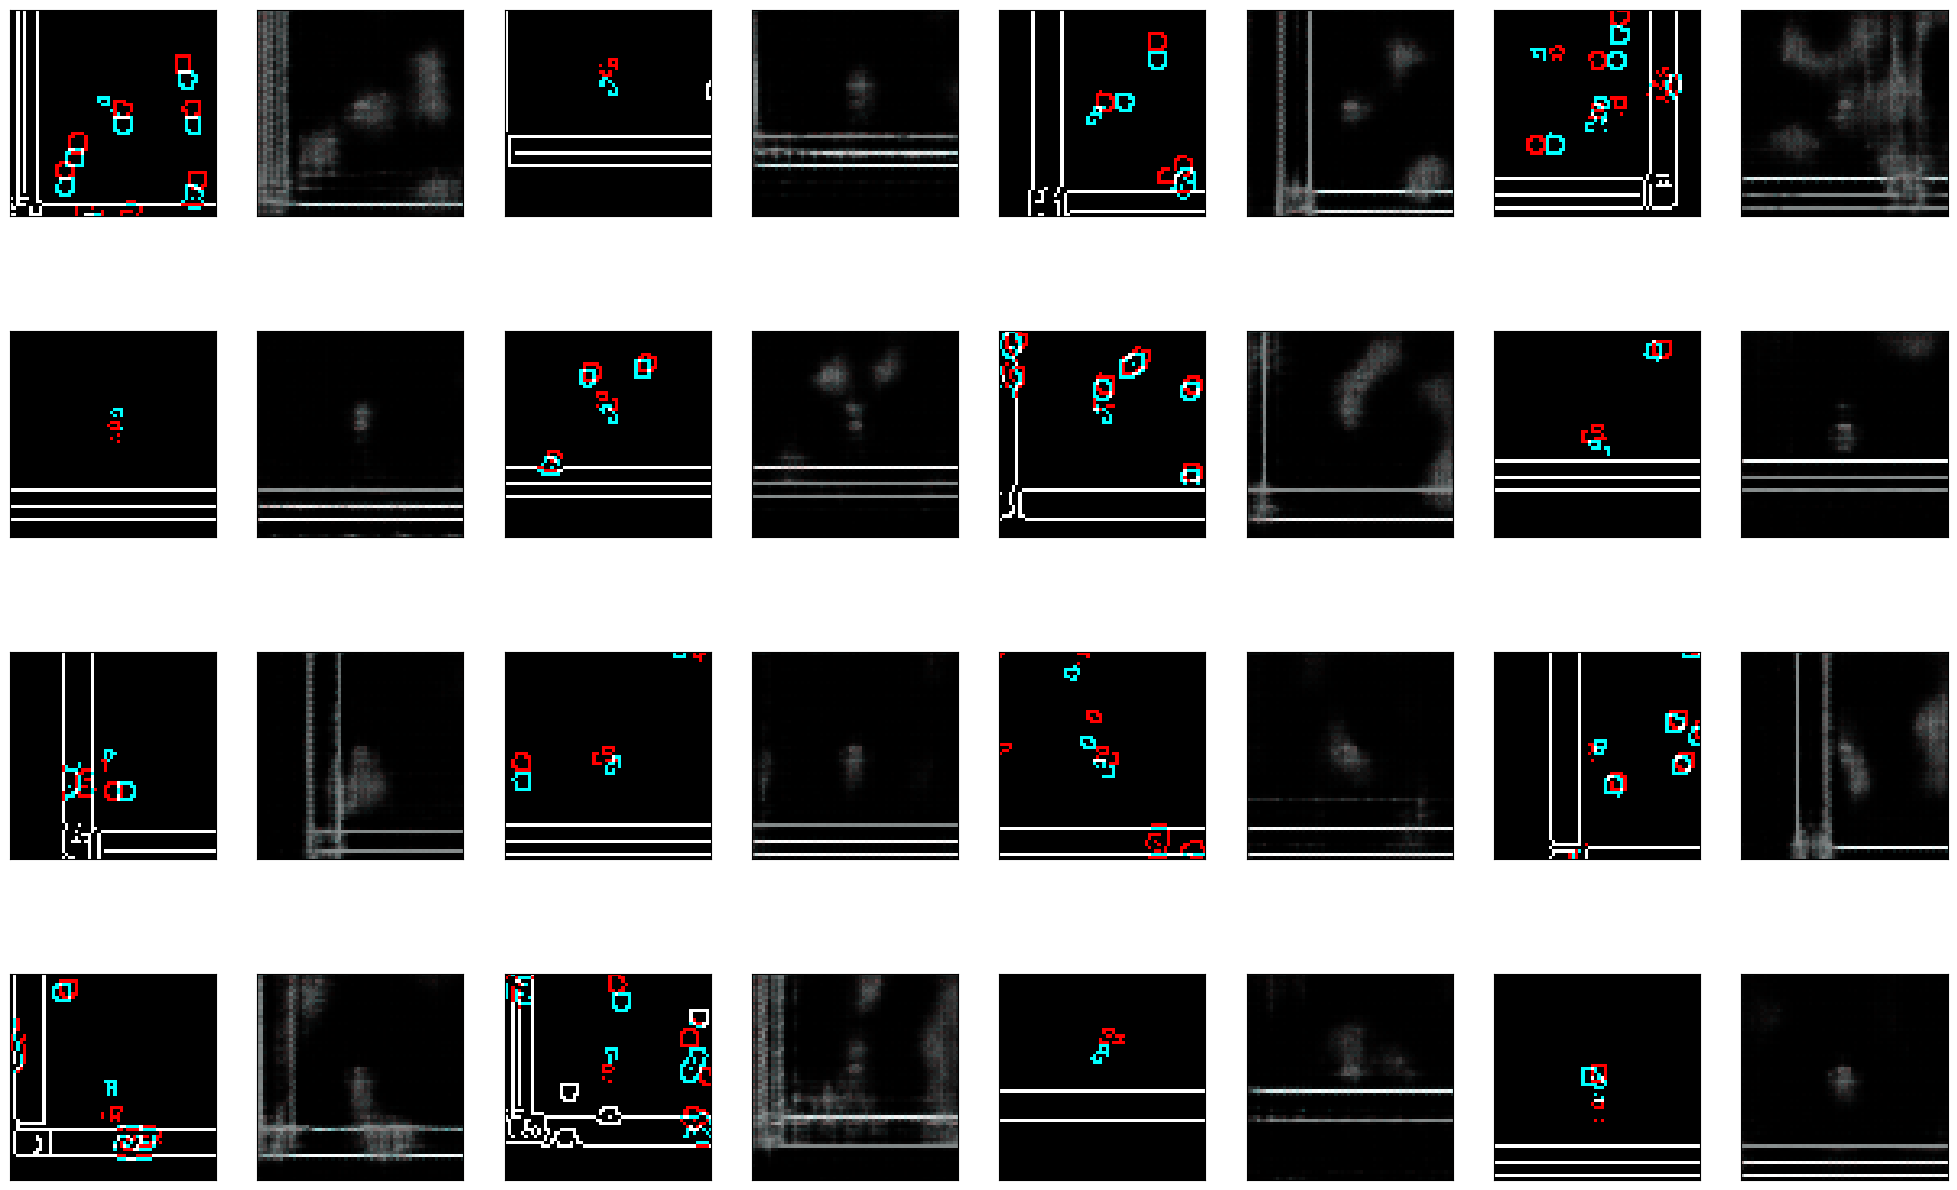

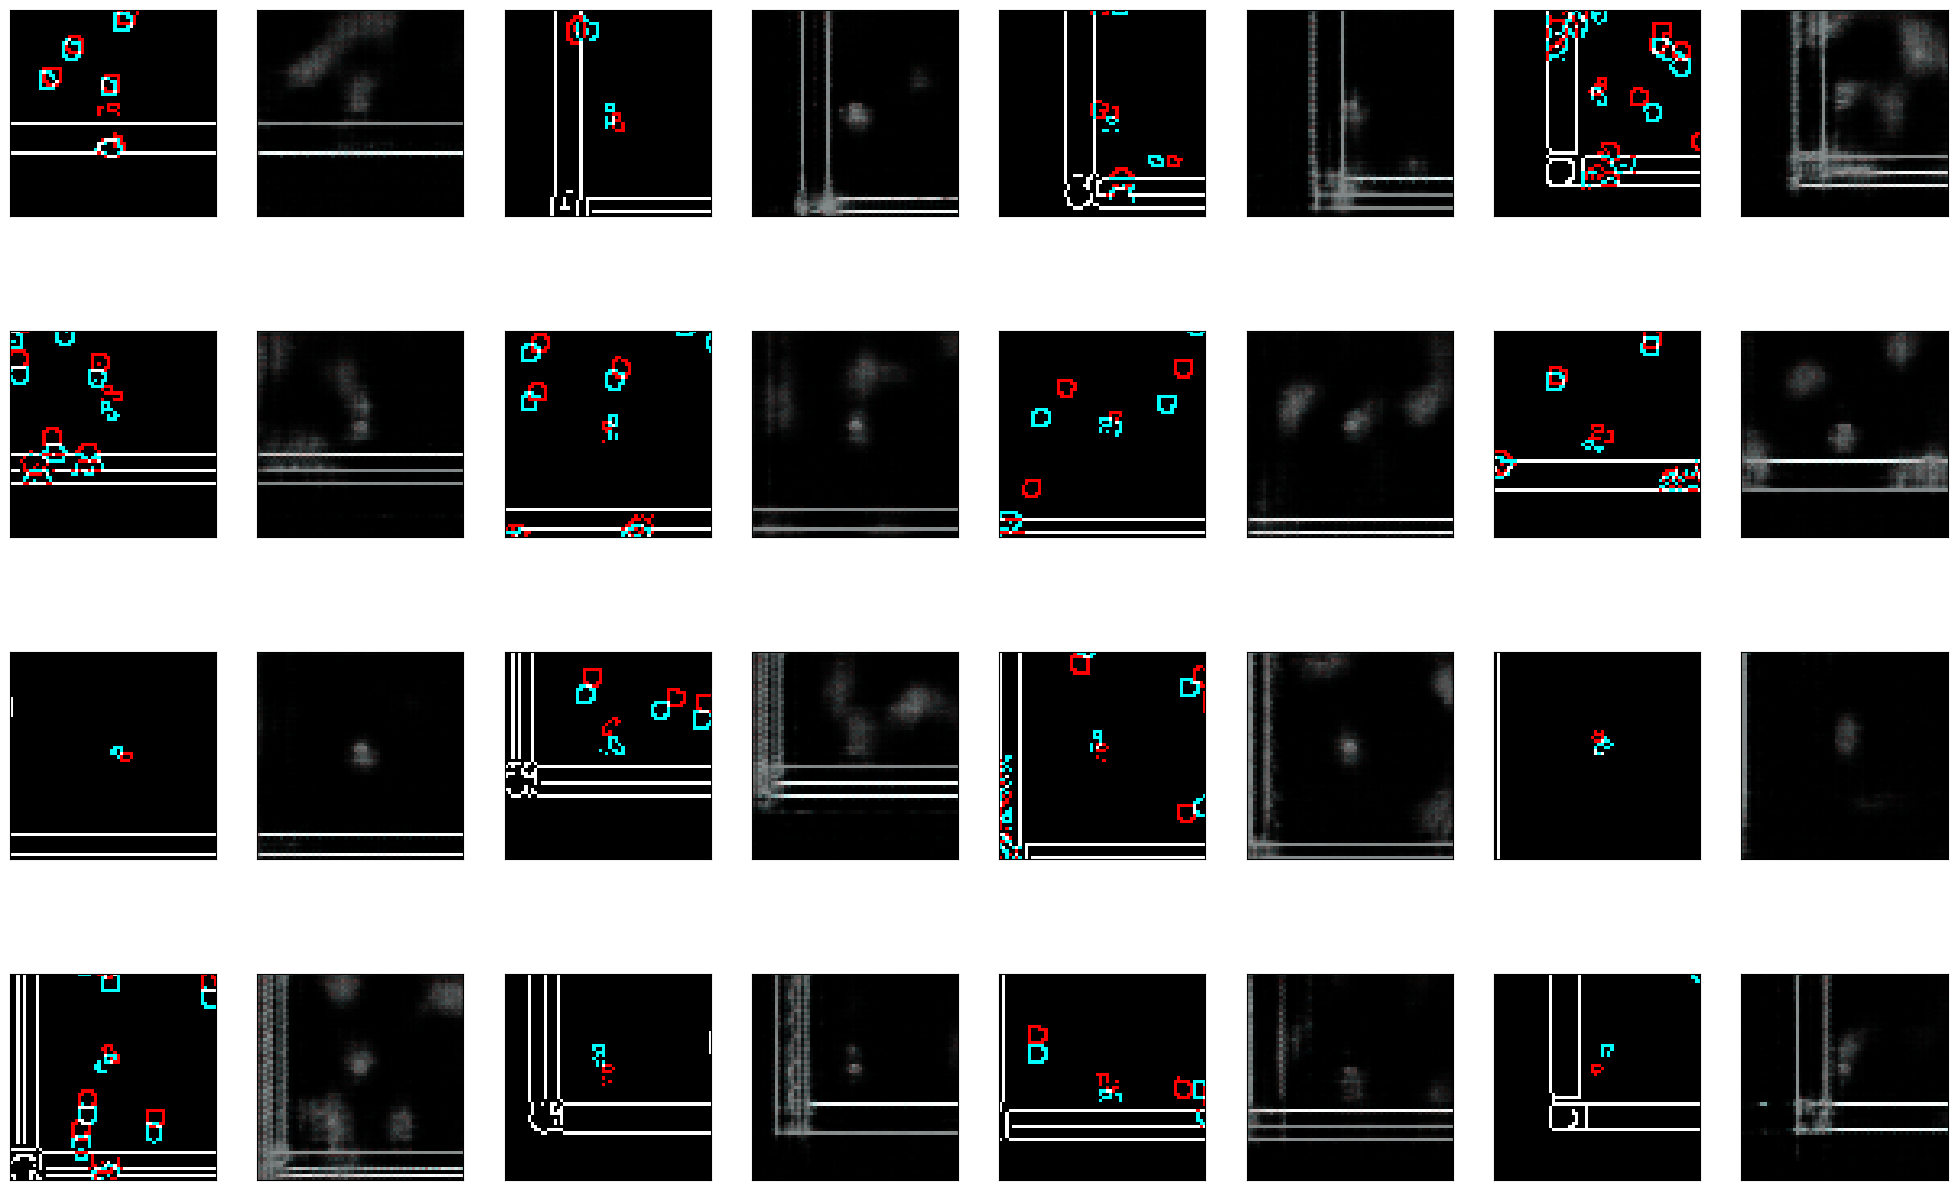

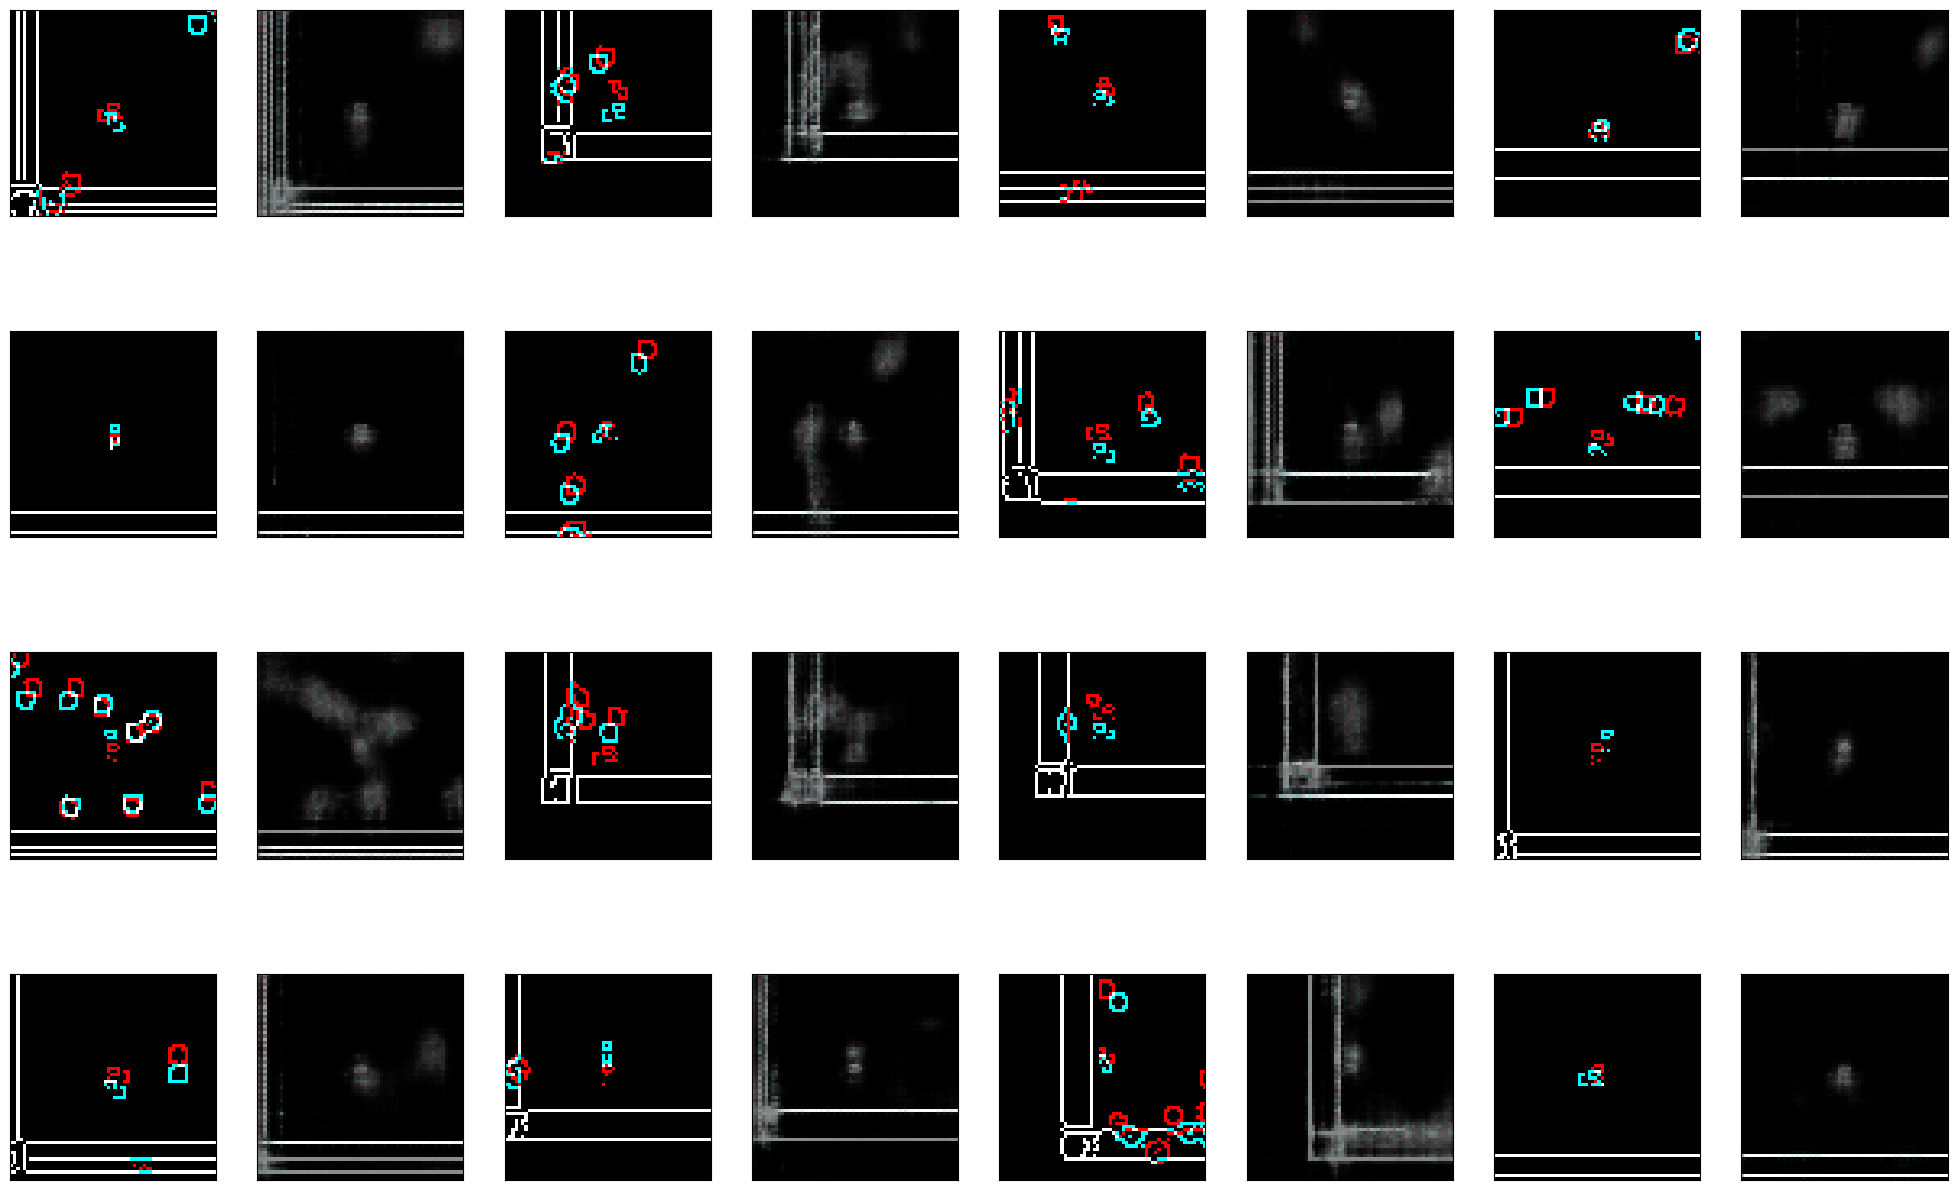

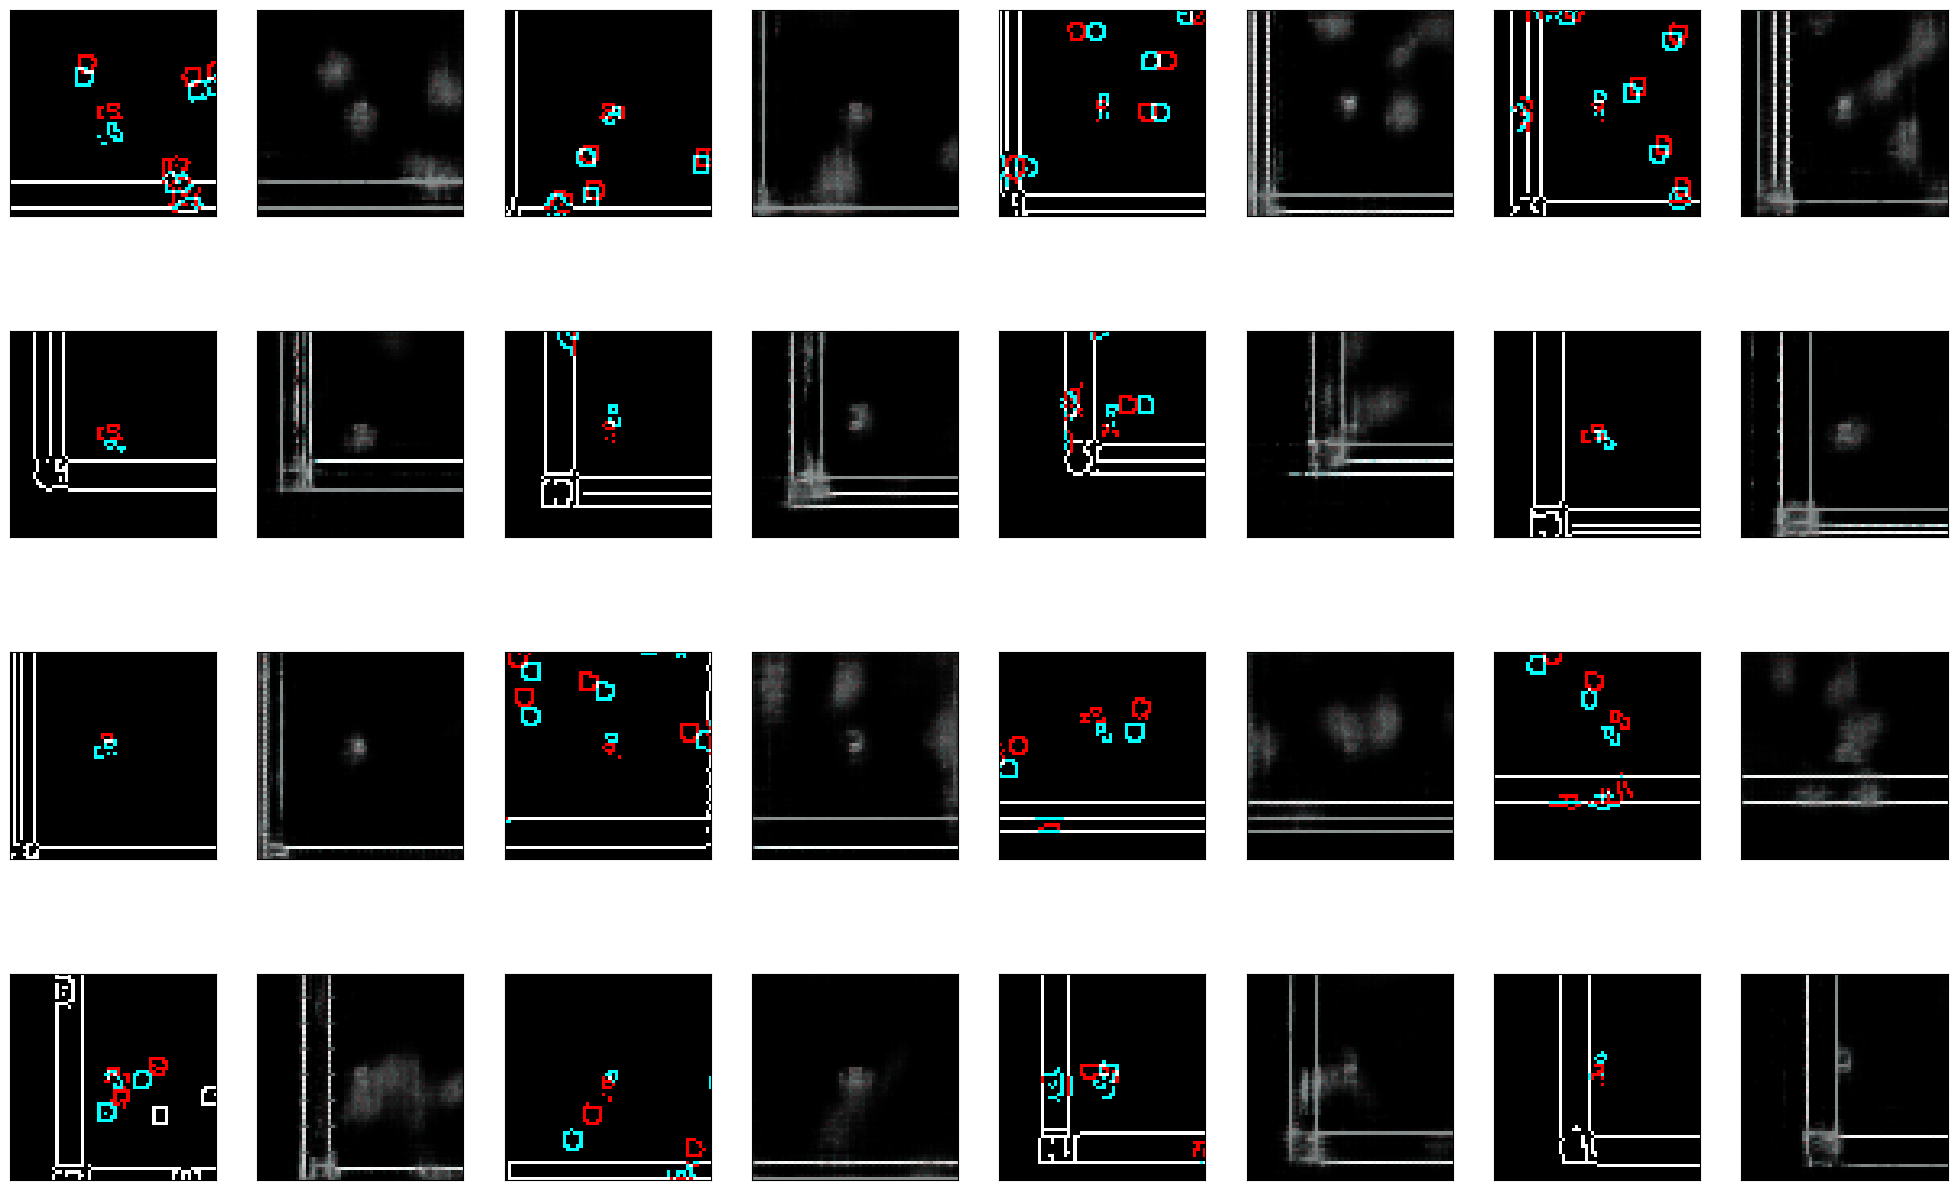

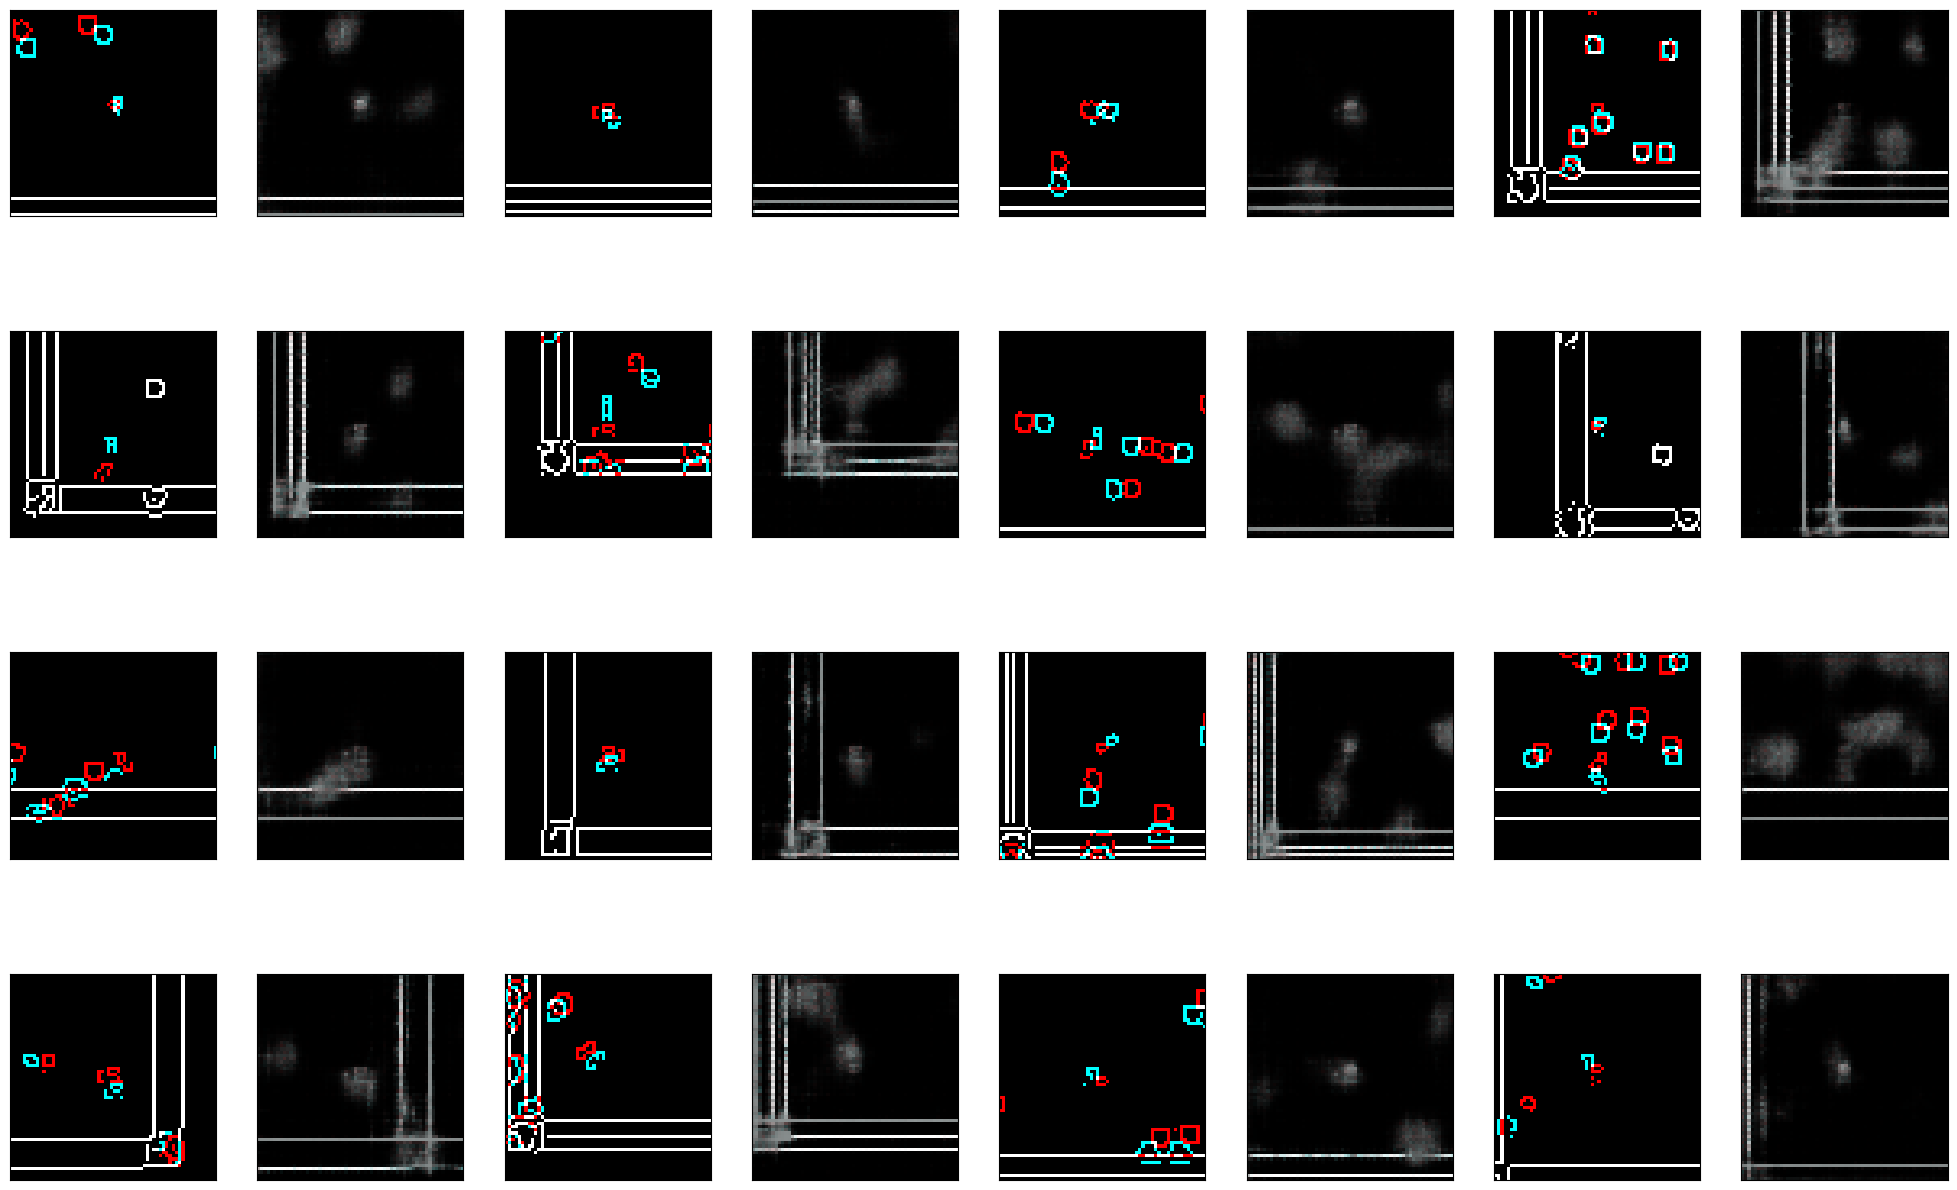

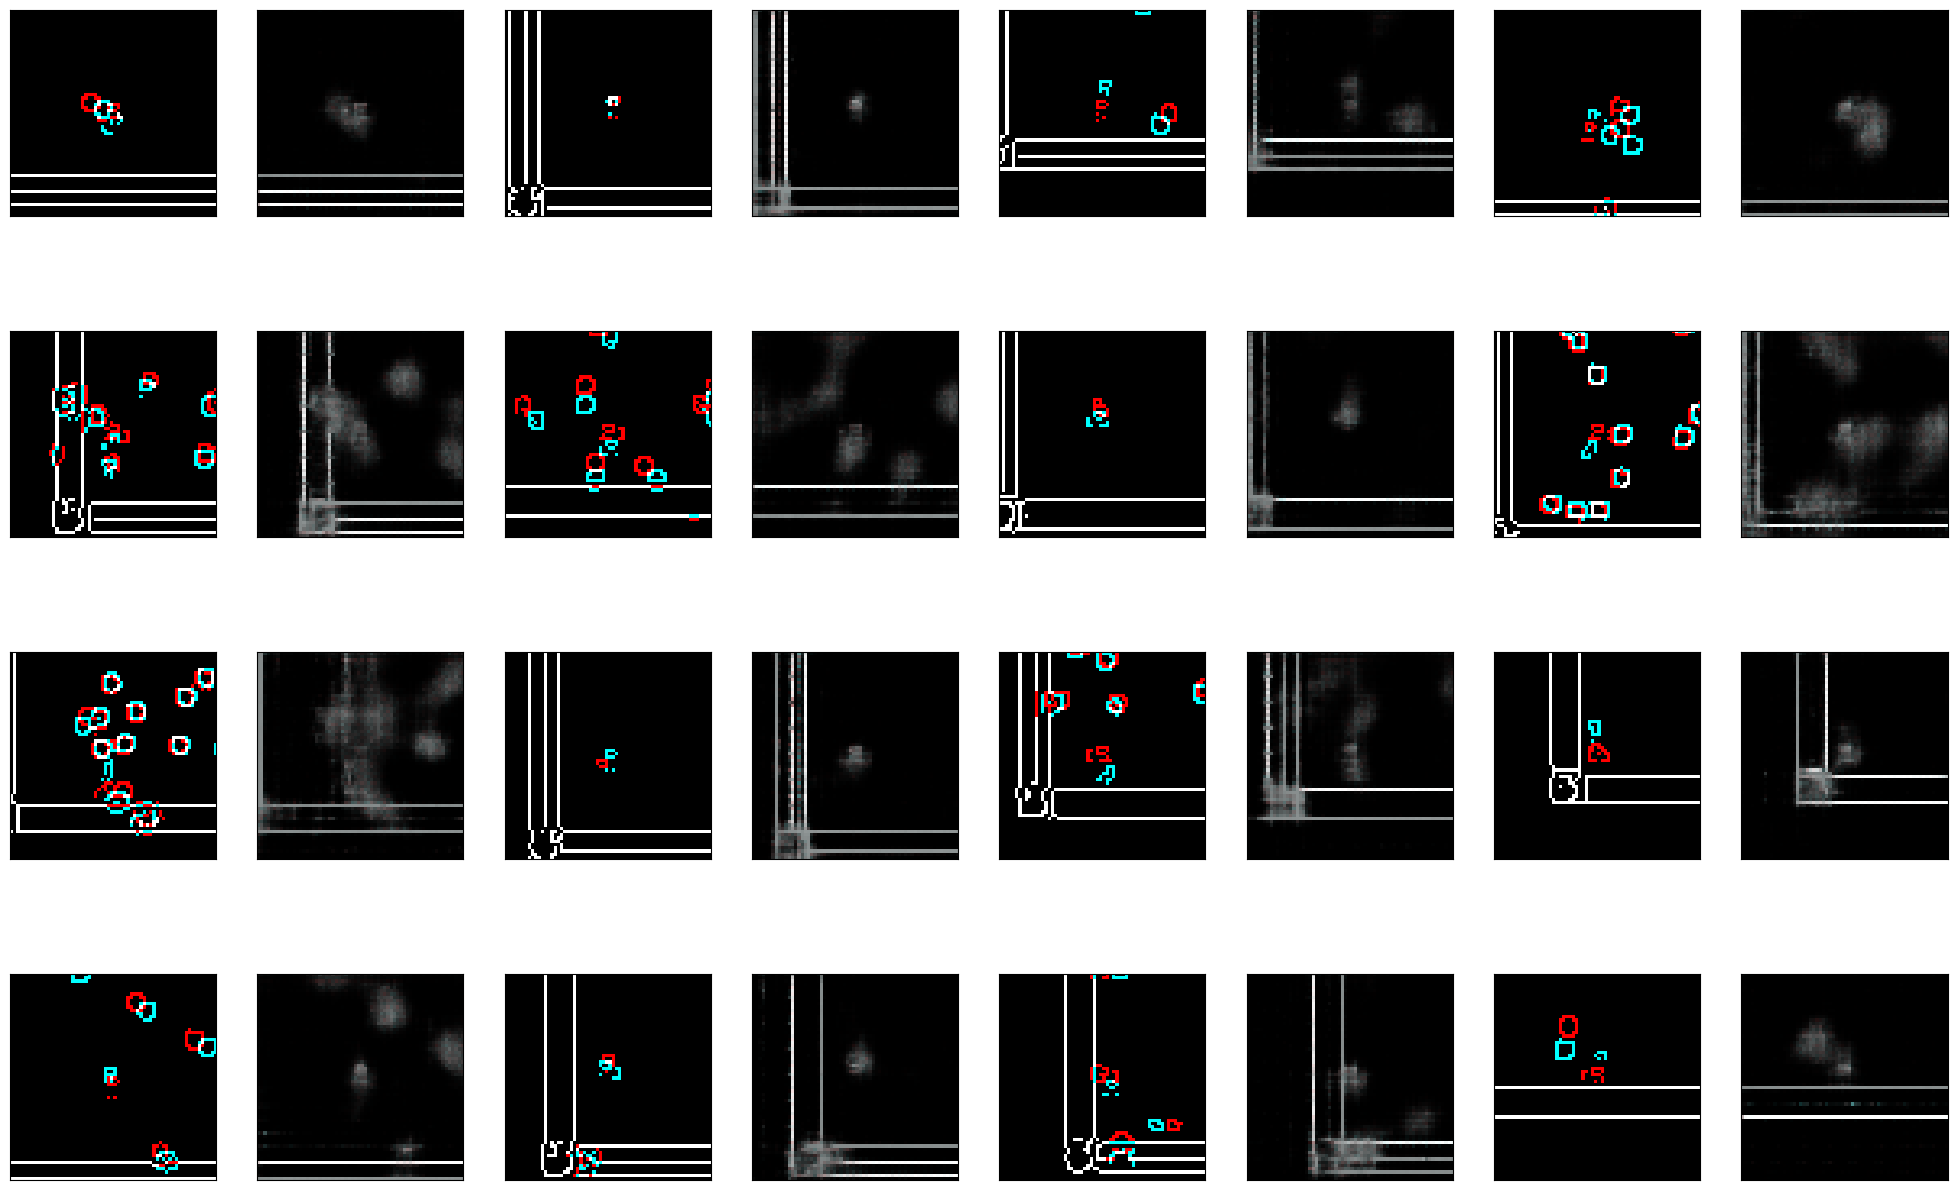

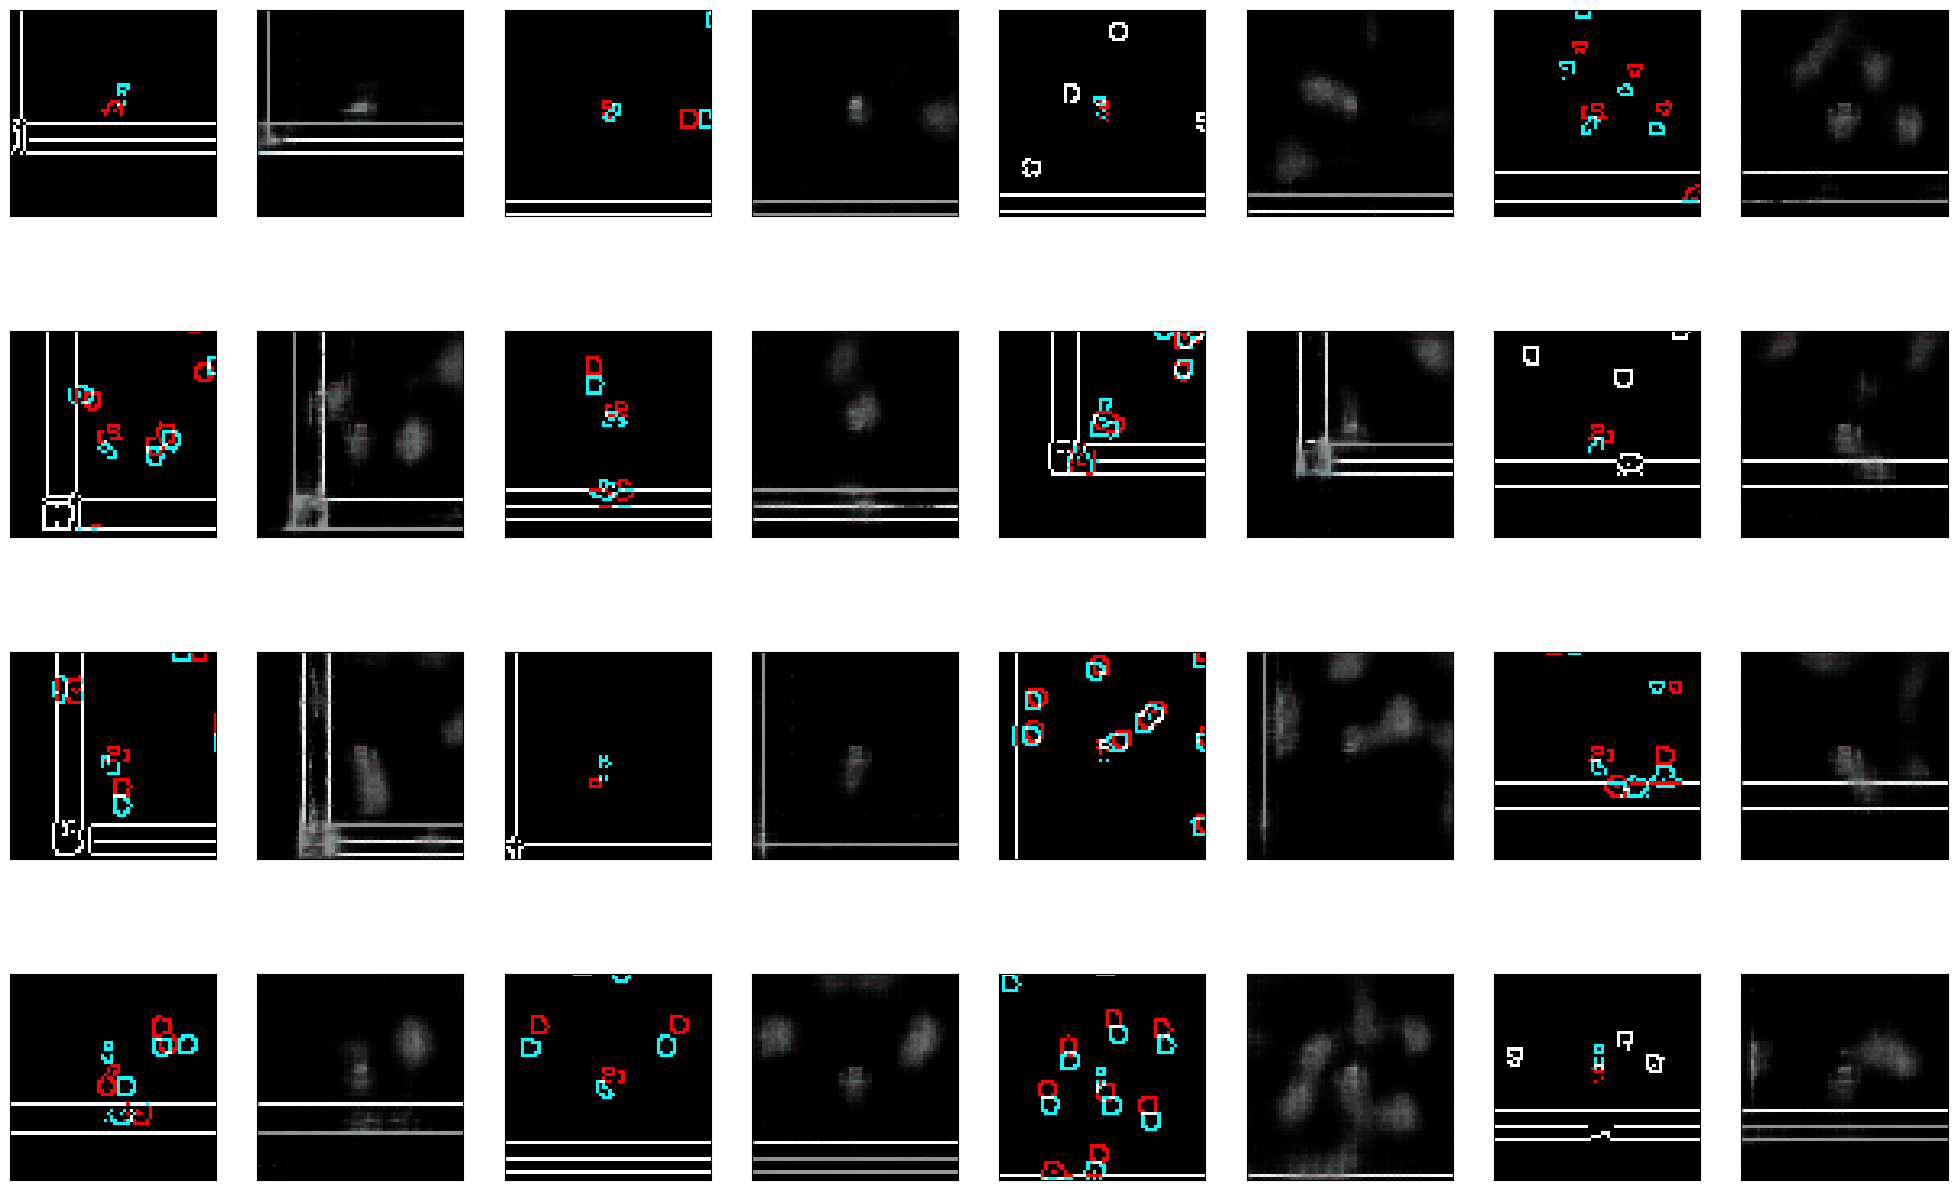

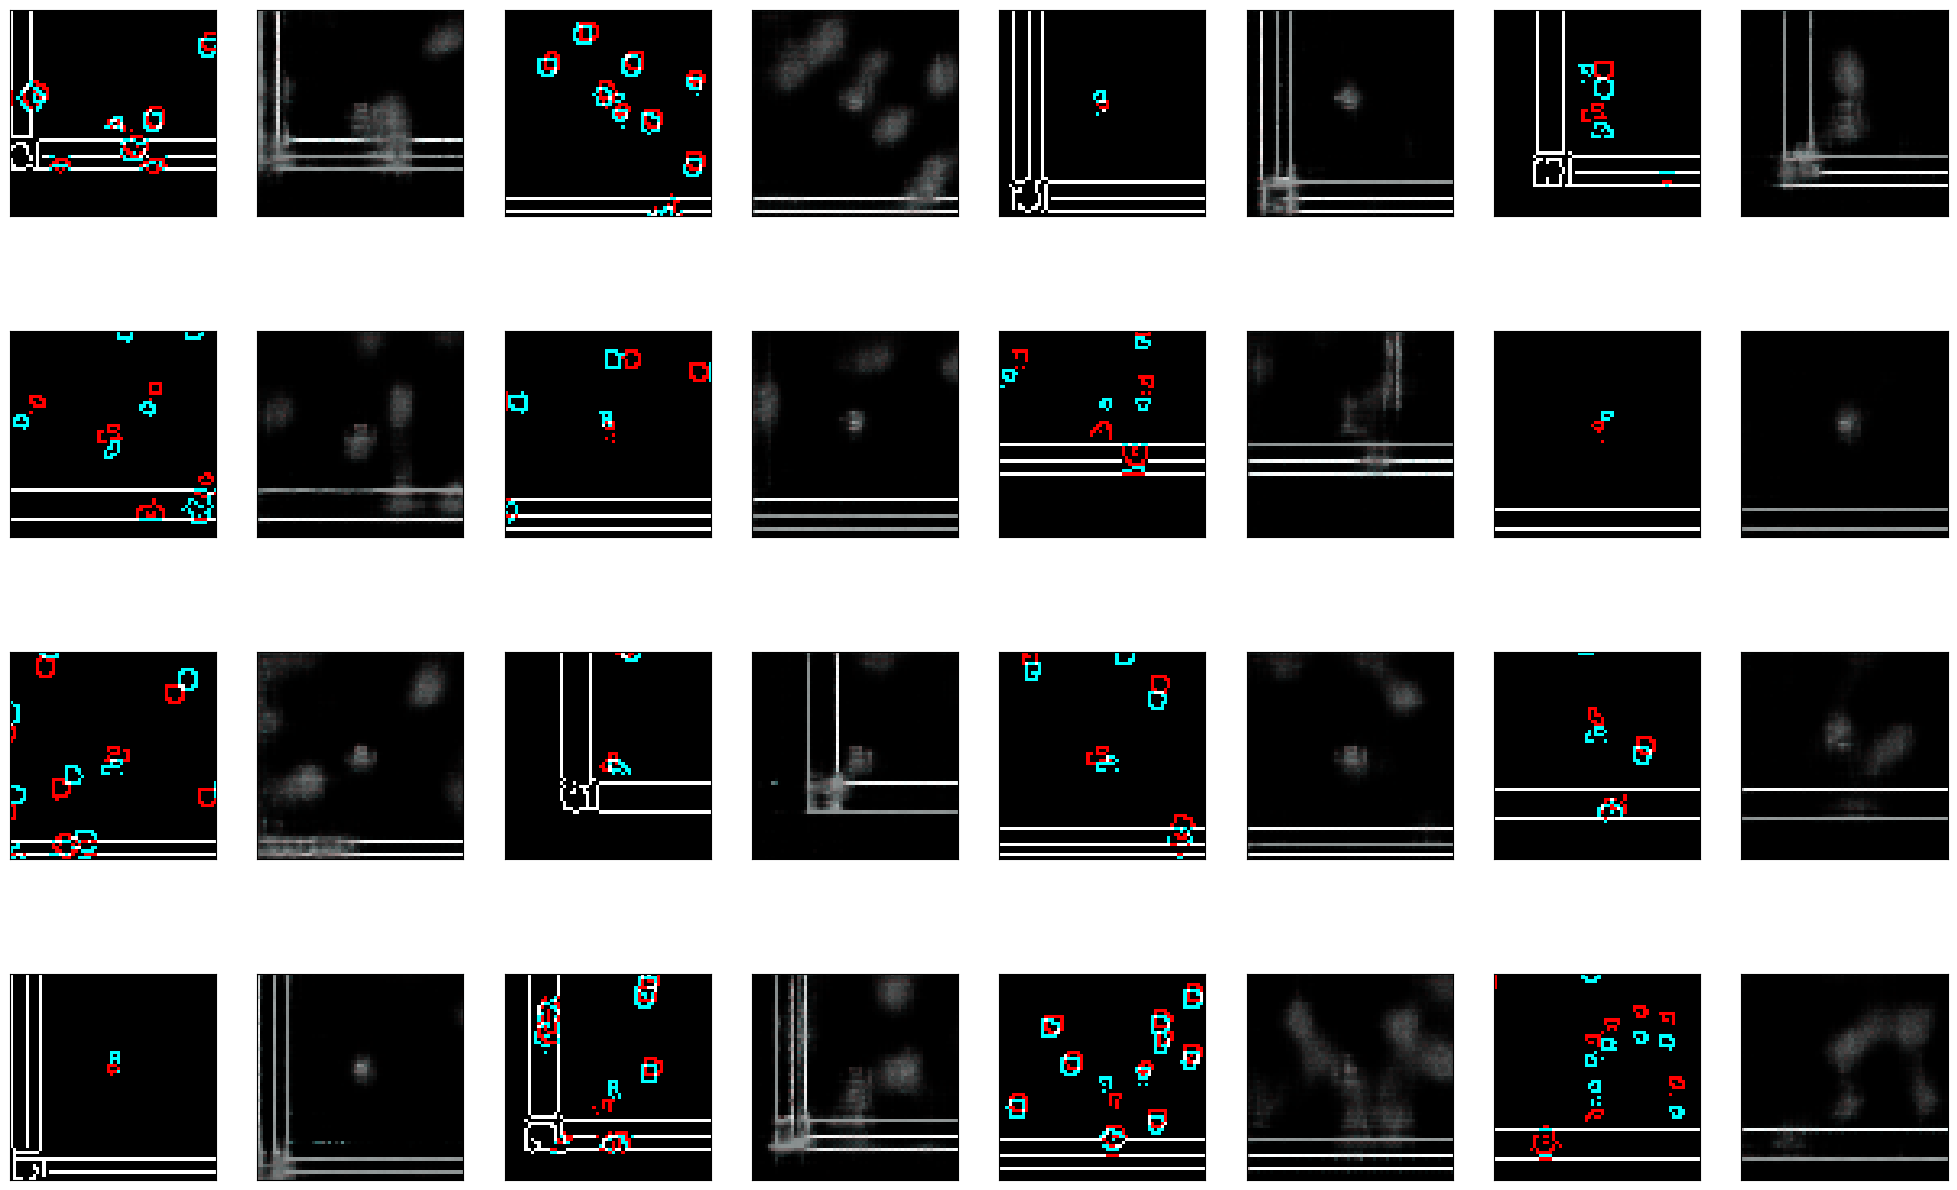

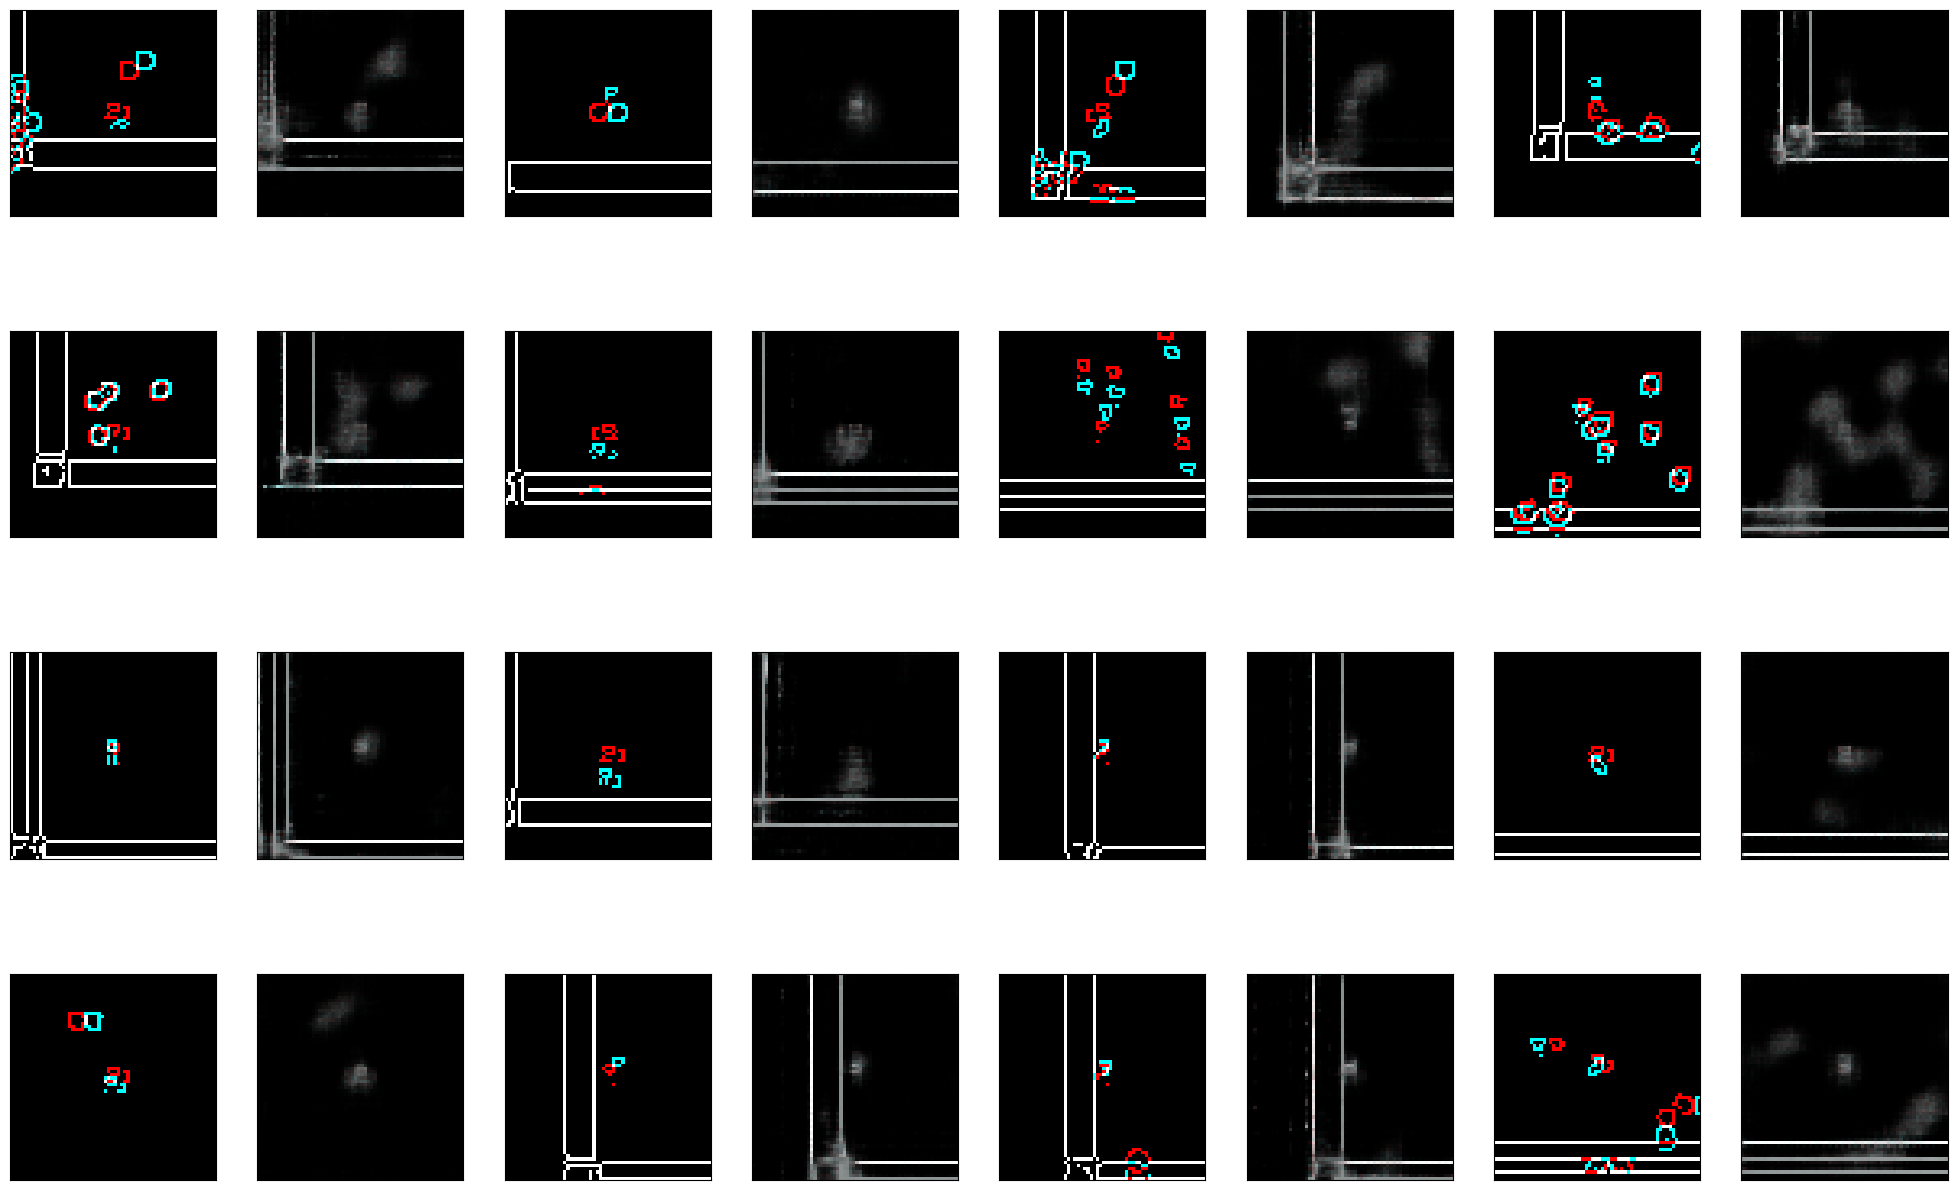

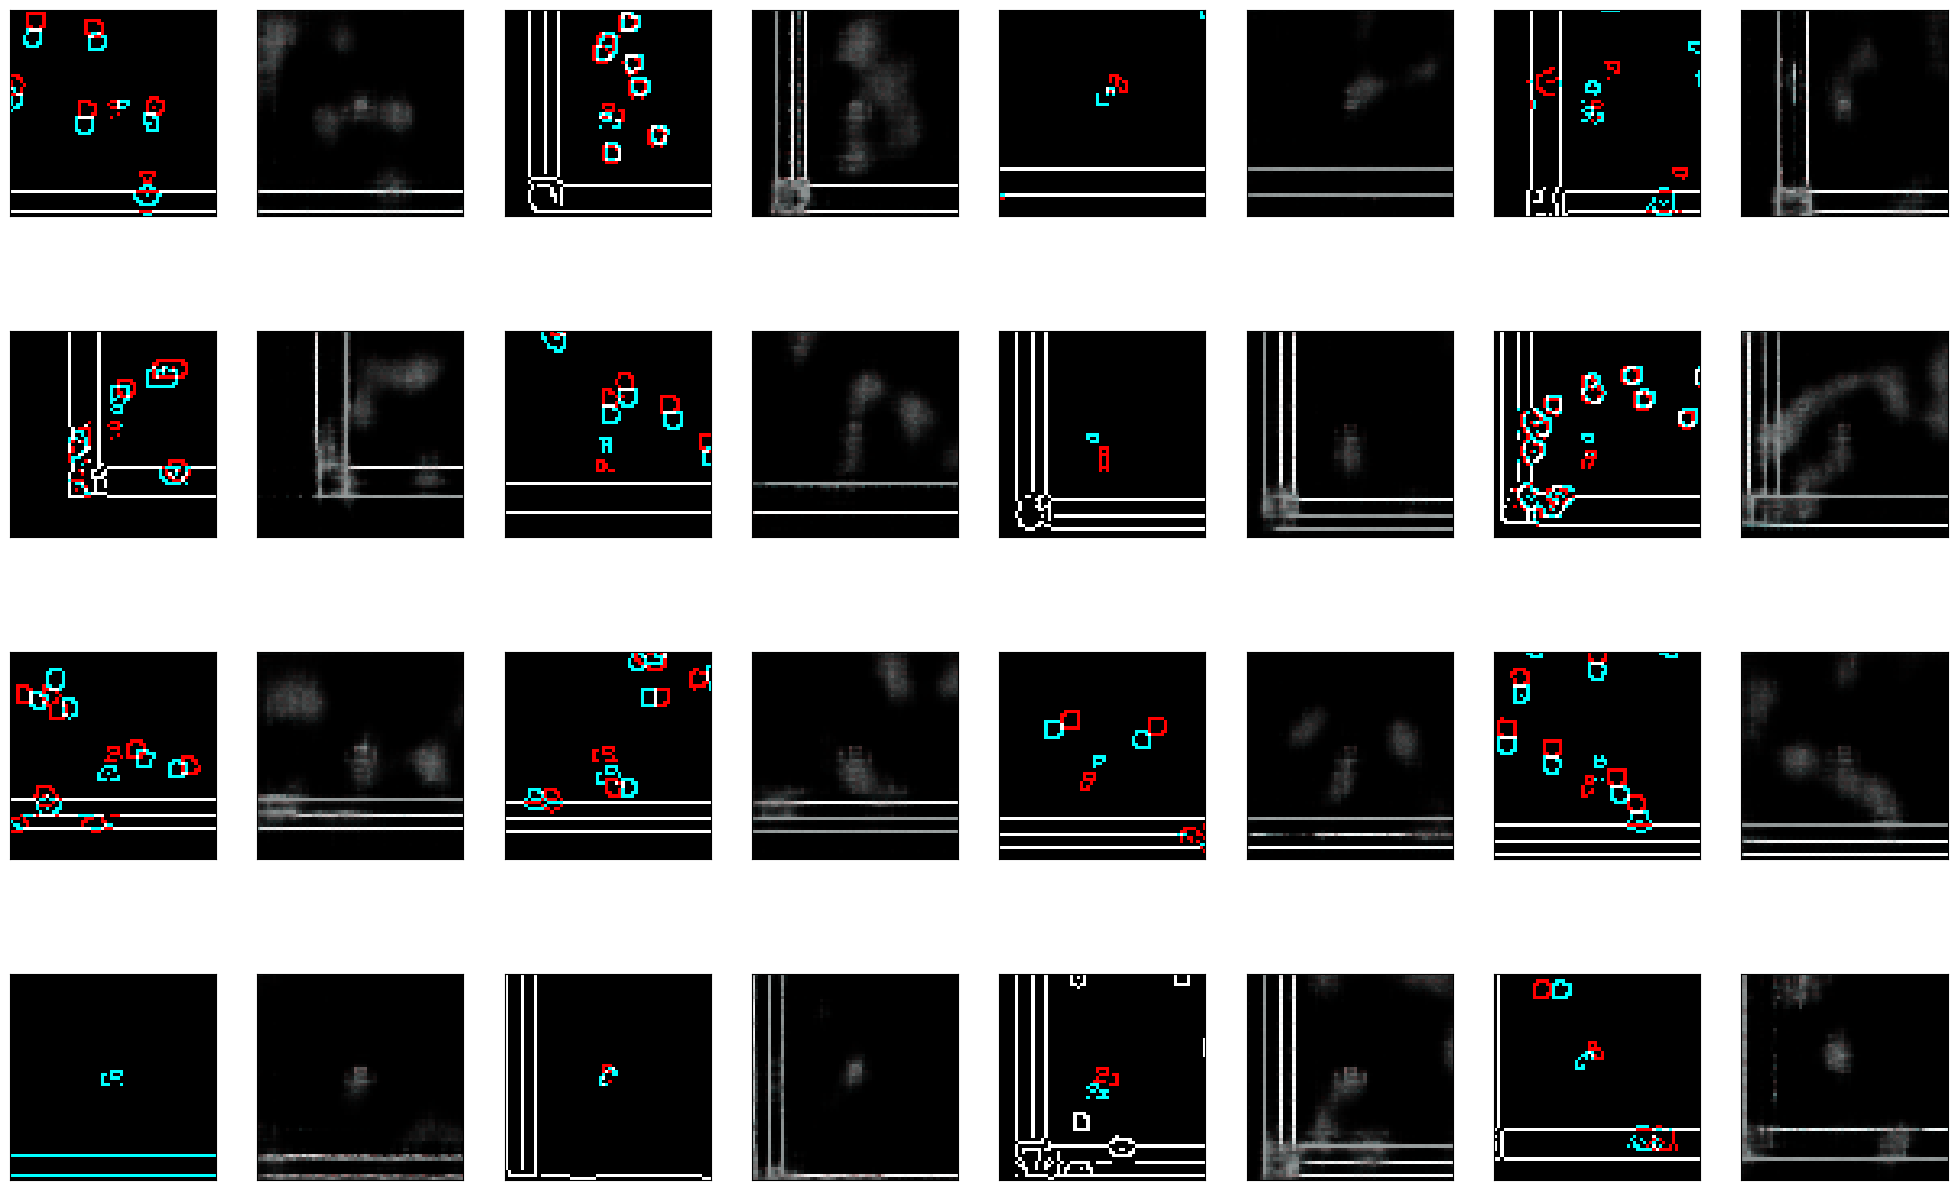

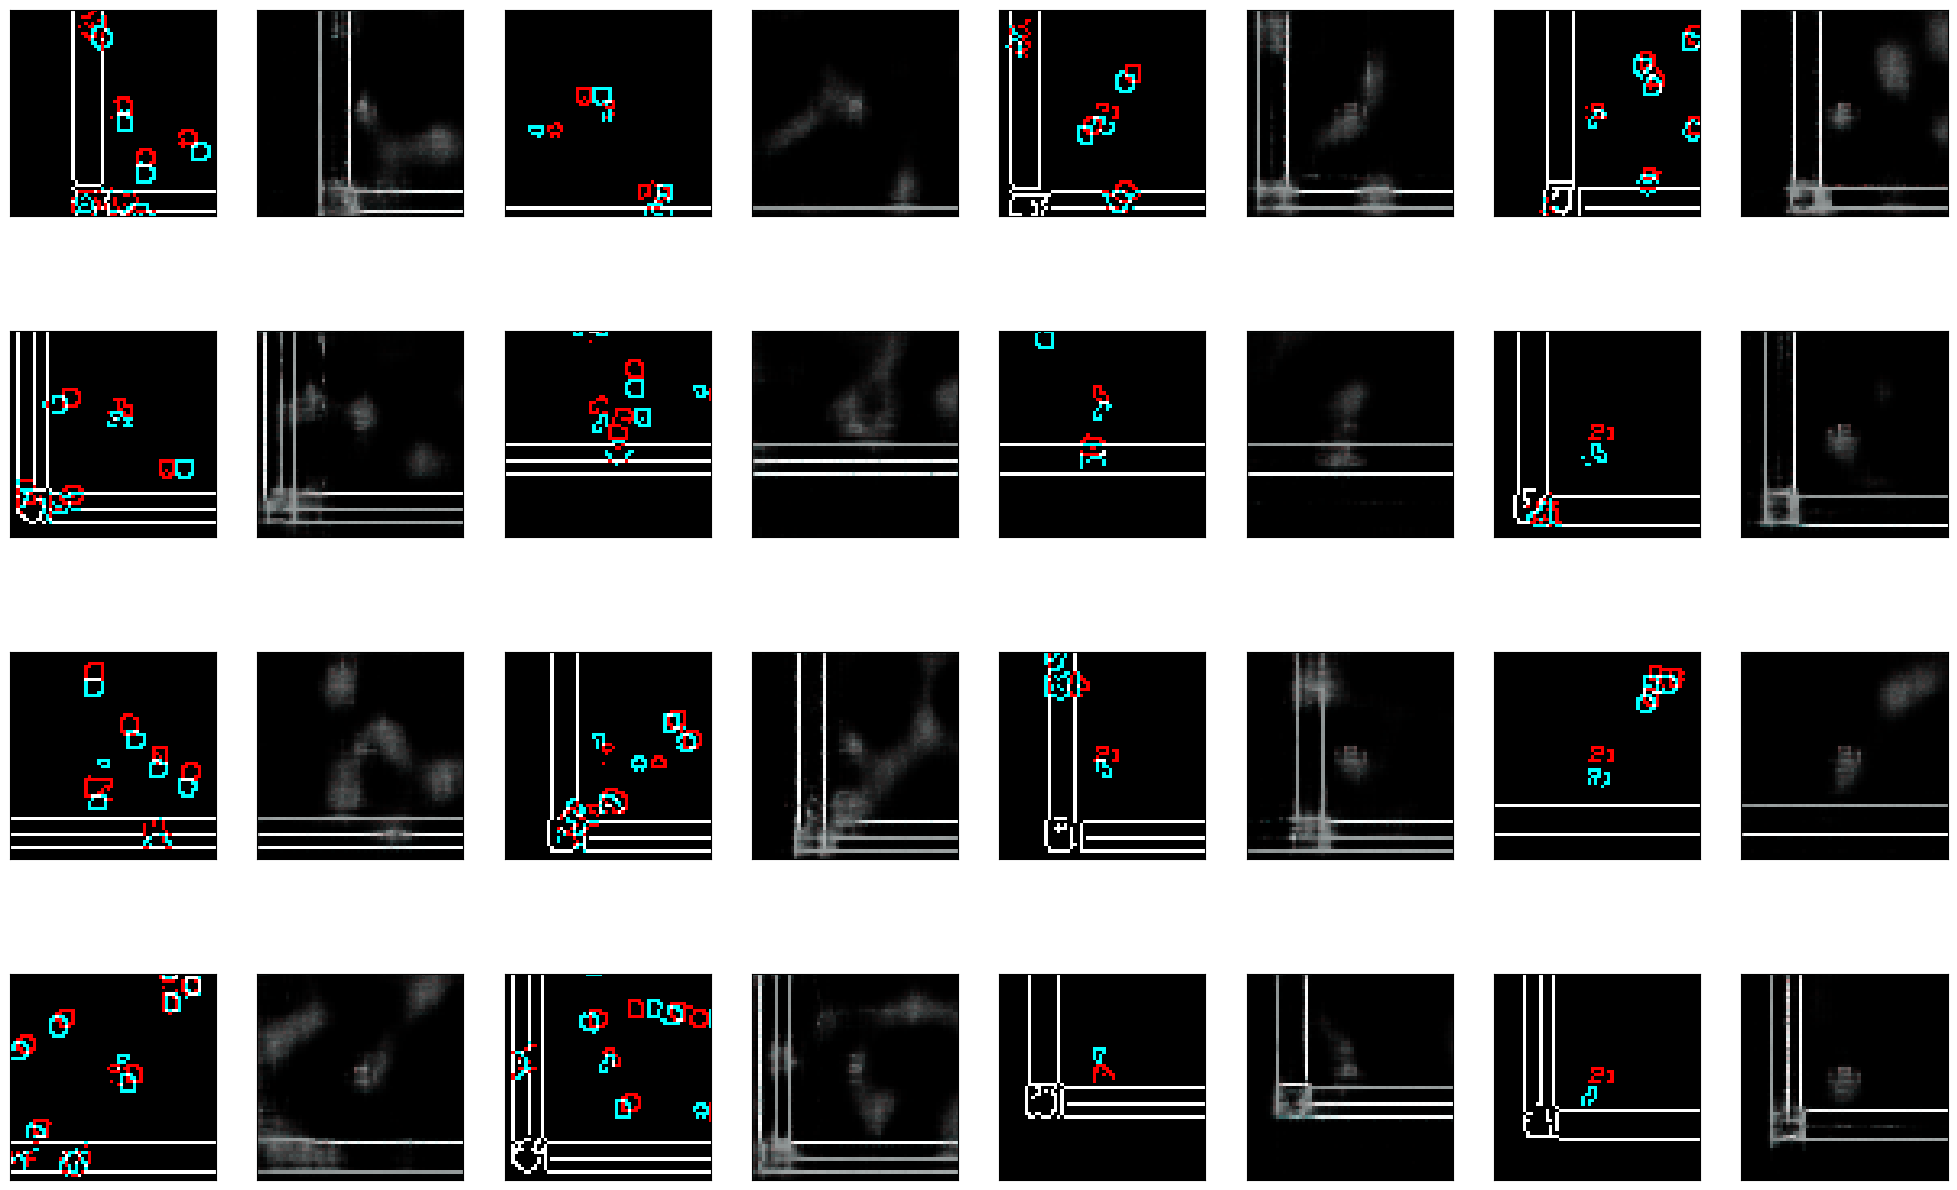

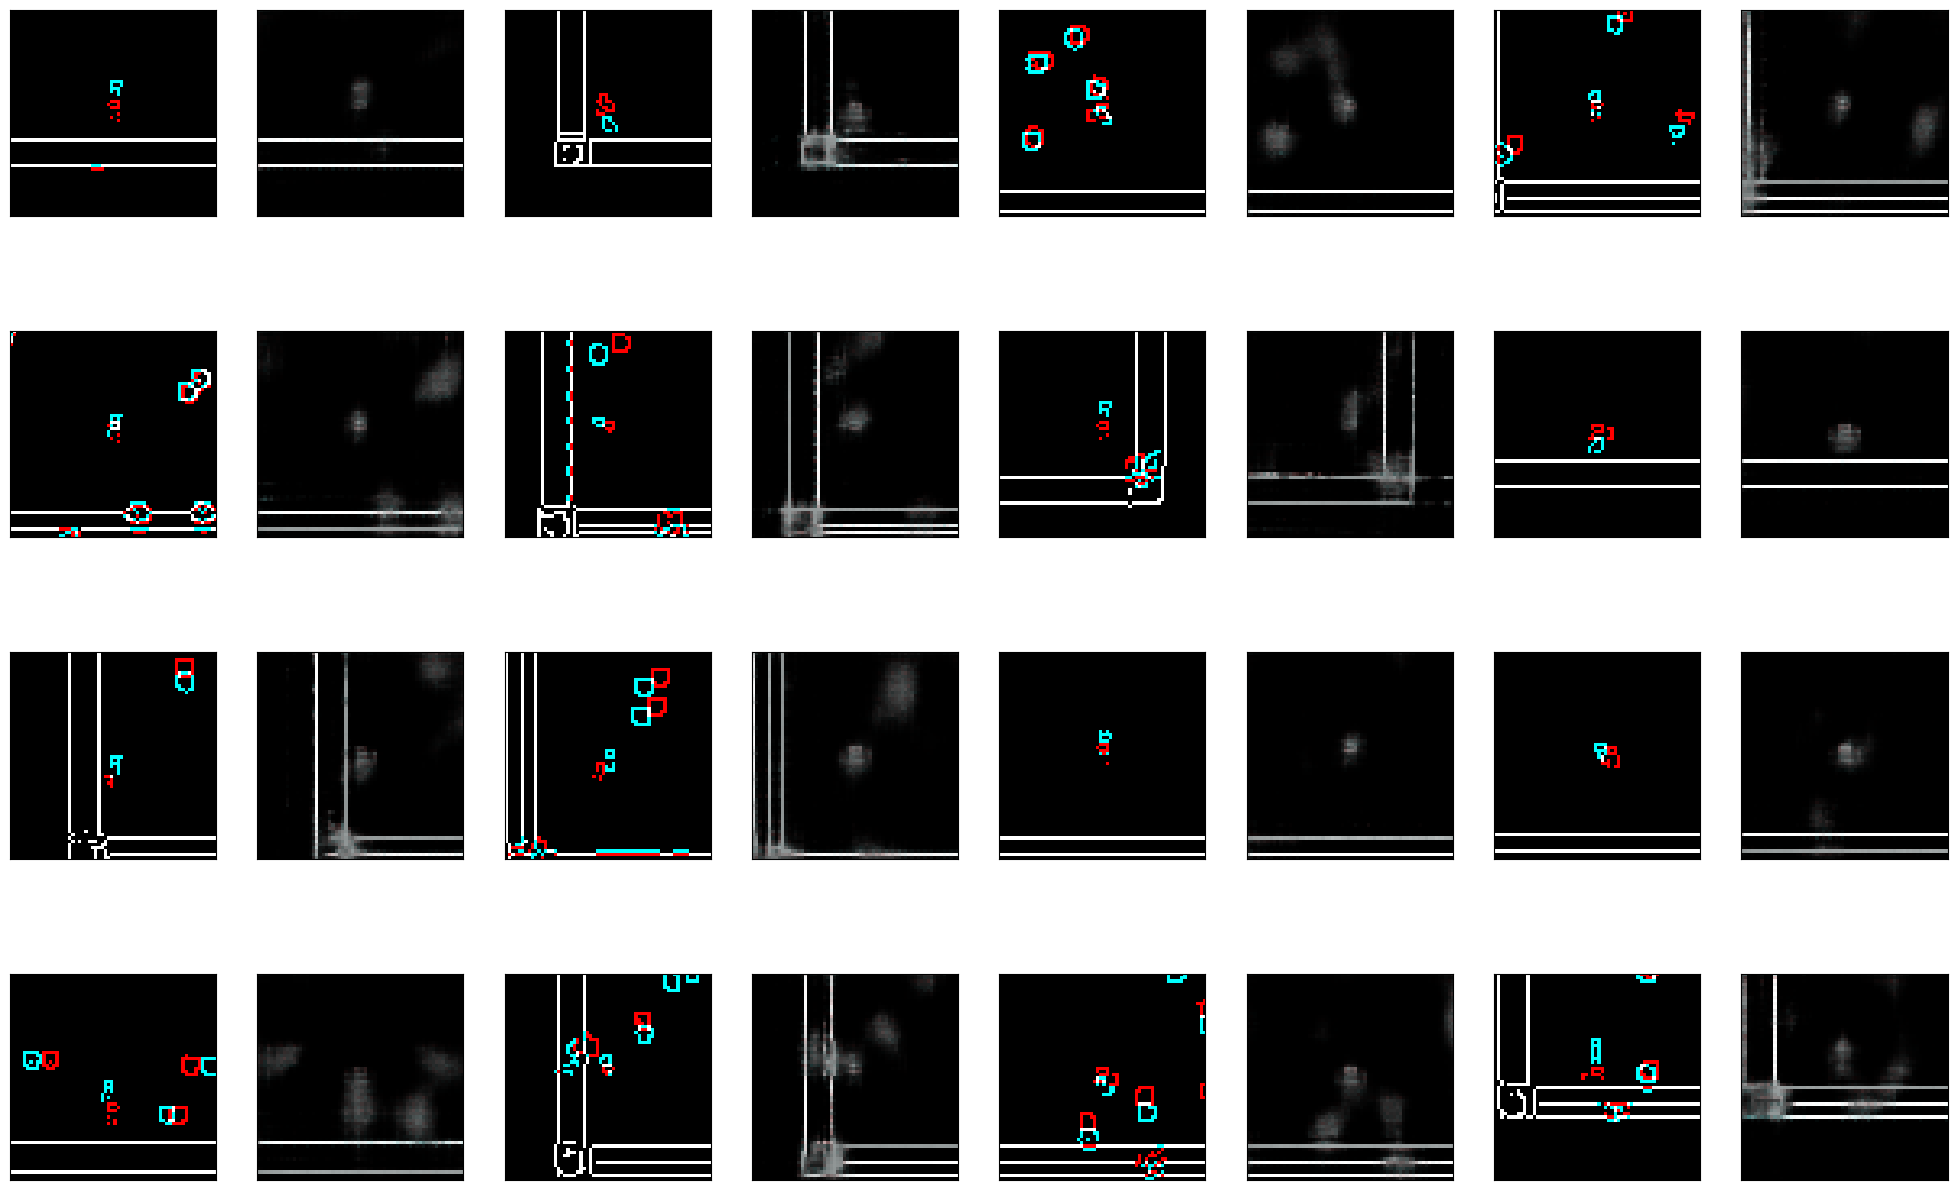

In [54]:
### Обучение для VAE
with torch.autograd.detect_anomaly():
    for i in np.arange(10000):
        (_, data) = next(iter(dataloader))
        data = data.to(device)
        optimizer.zero_grad()

        data_recon, x, mu, log_var = model(data)
    #     print(data_recon.shape, data.shape)
        model_loss = model.loss_f(data_recon, data, mu, log_var, ENTROPY_W=entropy_weight, M_N=kld_weight)
        loss = model_loss['loss']
        recon_error = model_loss['Reconstruction_Loss']
        KLD = model_loss['KLD']
        
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        
        optimizer.step()

        train_res_recon_error.append(recon_error.item())
        train_res_KLD.append(KLD.item())

        if (count+1) % 25 == 0:
            print('%d iterations' % (count+1))
            print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
            print('KLD: %.3f' % np.mean(train_res_KLD[-100:]))
            print()
        
        if (count+1) % 200 == 0:
            show_images(model, dataloader)
        
        if (count+1) % 500 == 0:
            torch.save(model.state_dict(), f'VQ_VAE_models/VAE{count}_im{image_size}x{image_size}_emb{embedding_image_size}x{embedding_image_size}-{embedding_dim}-{num_embeddings}_hid{num_hiddens}_edge.pt')
            show_images(model, dataloader)
        count += 1



In [53]:
### Обучение для VQ-VAE
for i in np.arange(10000):
    (data, _) = next(iter(dataloader))
    data = data.to(device)
    optimizer.zero_grad()

    vq_loss, data_recon, perplexity = model(data)
#     print(data_recon.shape)
    recon_error = edge_loss(data_recon, data) * 10
    loss = recon_error + vq_loss
    loss.backward()

    optimizer.step()
    
    train_res_recon_error.append(recon_error.item())
    train_res_vq_loss.append(vq_loss.item())
    train_res_perplexity.append(perplexity.item())

    if (count+1) % 25 == 0:
        print('%d iterations' % (count+1))
        print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
        print('vq_loss: %.3f' % np.mean(train_res_vq_loss[-100:]))
        print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
        print()
        
    count += 1



ValueError: too many values to unpack (expected 3)

In [45]:
torch.save(model.state_dict(), f'VQ_VAE_models/VAE{count}_im{image_size}x{image_size}_emb{embedding_image_size}x{embedding_image_size}-{embedding_dim}-{num_embeddings}_hid{num_hiddens}_edge.pt')

In [68]:
from scipy.signal import savgol_filter

In [69]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
train_res_vq_loss_smooth = savgol_filter(train_res_vq_loss, 201, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)

Text(0.5, 0, 'iteration')

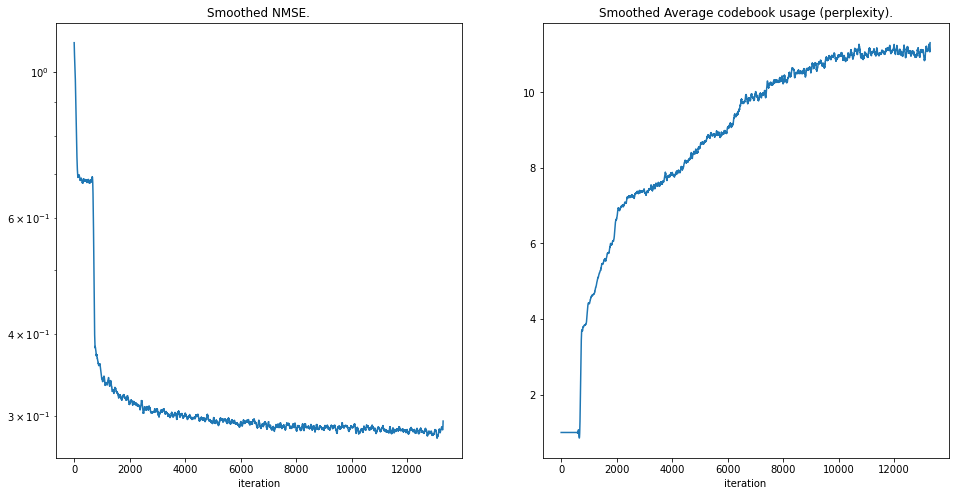

In [315]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,3,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,3,2)
ax.plot(train_res_vq_loss_smooth)
ax.set_title('Smoothed vq_loss.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,3,3)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

In [37]:
os.chdir('C:/Users/user/')

In [39]:
import cv2 

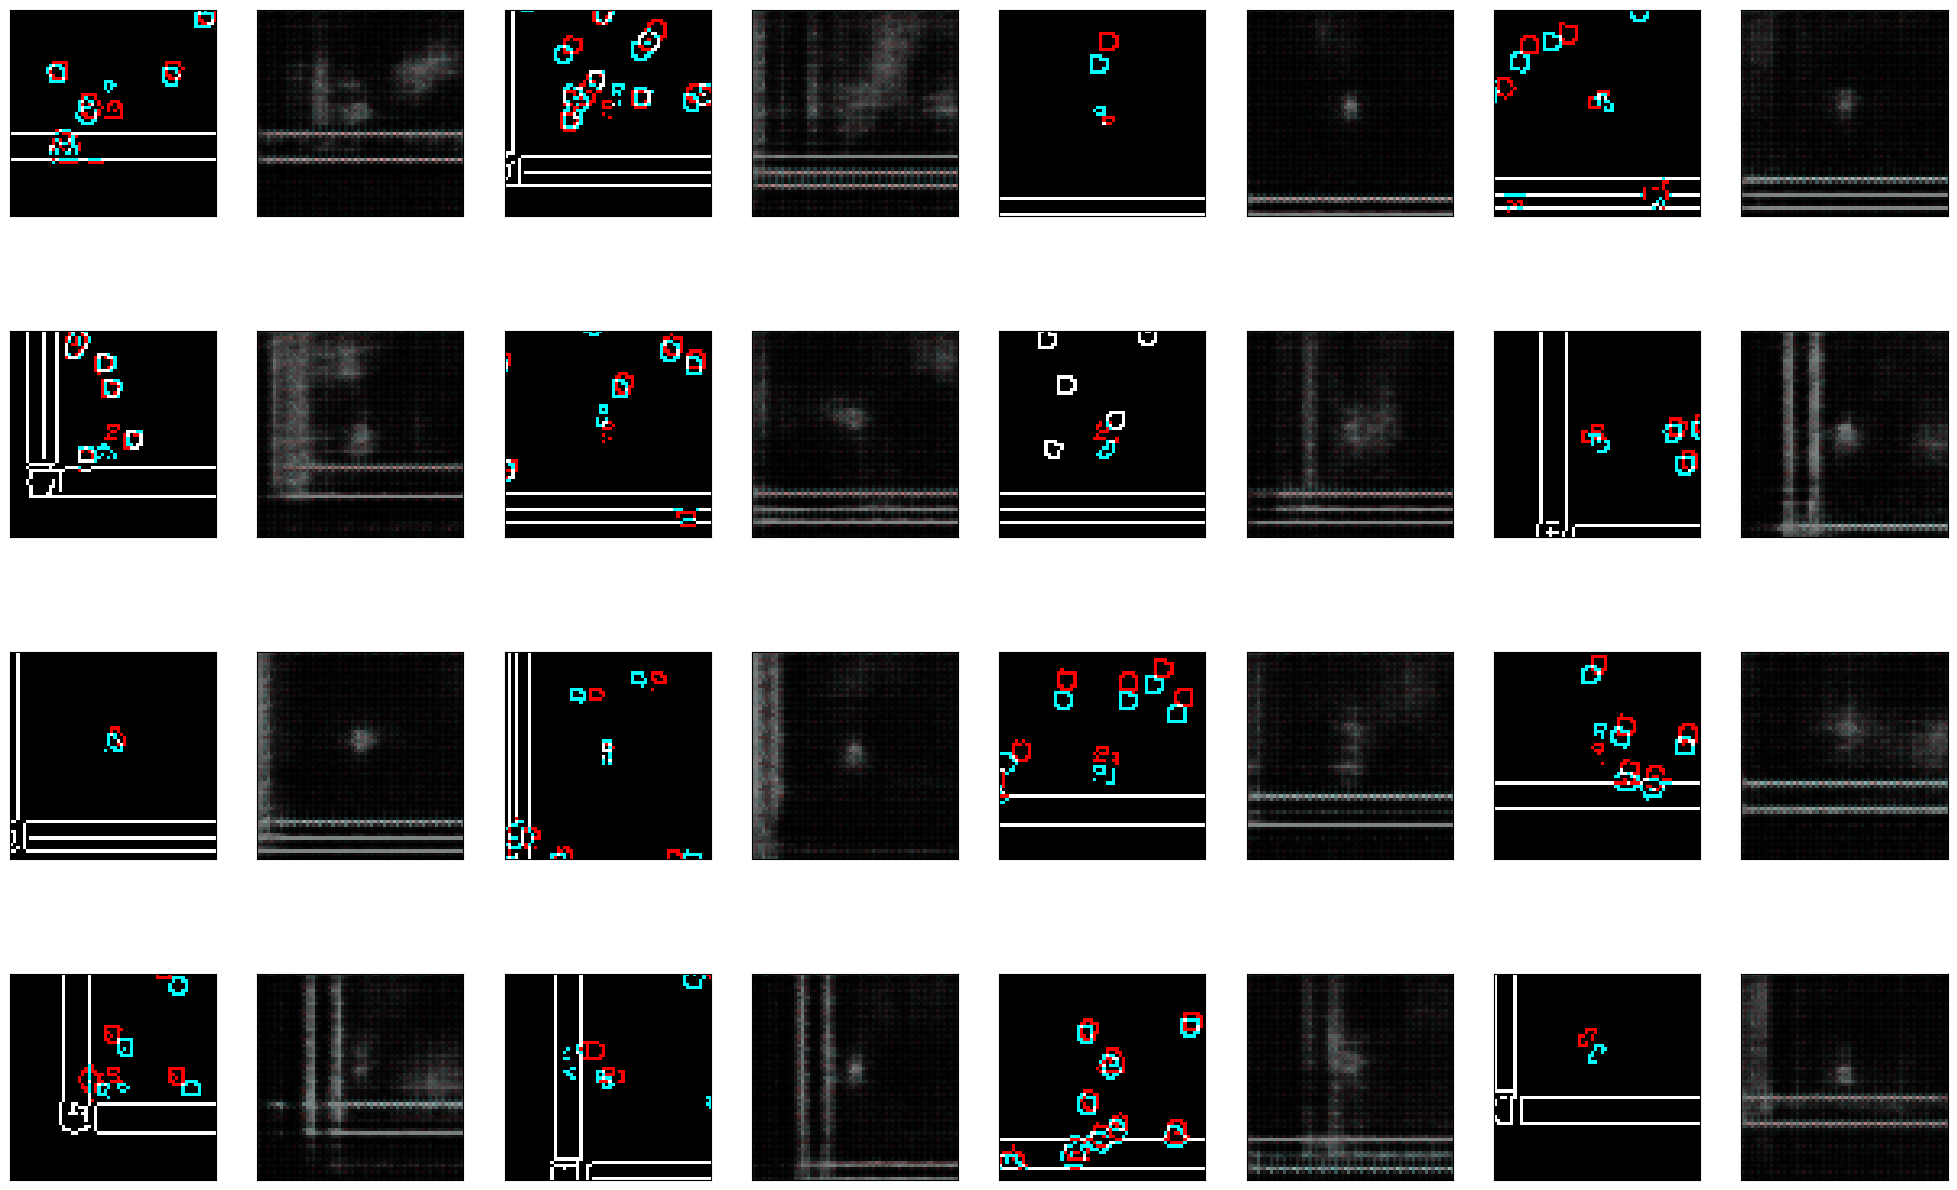

In [51]:
show_images(model, dataloader)

In [41]:
for param in model.parameters():
    print(param.data.max())

tensor(0.3474, device='cuda:8')
tensor(0.3317, device='cuda:8')
tensor(1.0592, device='cuda:8')
tensor(0.4619, device='cuda:8')
tensor(0.2587, device='cuda:8')
tensor(0.0797, device='cuda:8')
tensor(1.3790, device='cuda:8')
tensor(0.4831, device='cuda:8')
tensor(0.3574, device='cuda:8')
tensor(0.0820, device='cuda:8')
tensor(1.1704, device='cuda:8')
tensor(0.3878, device='cuda:8')
tensor(0.2796, device='cuda:8')
tensor(0.0581, device='cuda:8')
tensor(0.9346, device='cuda:8')
tensor(0.1032, device='cuda:8')
tensor(0.2619, device='cuda:8')
tensor(0.0545, device='cuda:8')
tensor(1.1699, device='cuda:8')
tensor(0.2280, device='cuda:8')
tensor(0.2630, device='cuda:8')
tensor(0.0773, device='cuda:8')
tensor(1.0610, device='cuda:8')
tensor(0.3242, device='cuda:8')
tensor(0.2401, device='cuda:8')
tensor(0.0085, device='cuda:8')
tensor(1.5176, device='cuda:8')
tensor(0.5660, device='cuda:8')
tensor(0.4707, device='cuda:8')
tensor(-0.3682, device='cuda:8')
tensor(0.2043, device='cuda:8')
tensor(

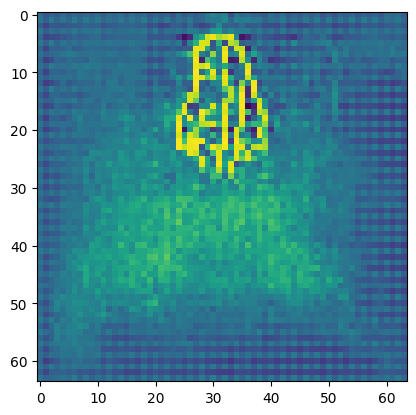

In [240]:
# _, data_recon, _ = model(x.to(device))
data_recon, _, _, _ = model(x.to(device))
img = (data_recon[4].cpu().detach().numpy().transpose(1,2,0))
plt.imshow(img)
# print(img)